# Выпускной проект: Промышленность

Металлургический комбинат «Стальная птица» оптимизирует производственные расходы, для этого комбинат решил уменьшить потребление электроэнергии на этапе обработки стали путем контроля температуры сплава.  

Металлургический комбинат хочет использовать разработанную модель для имитации технологического процесса.

**Цель проекта** — построить модель, которая будет предсказывать последнюю температуру по всей партии с метрикой MAE не более 6,8 на тестовой выборке, дополнительно вывести метрику r2 и обучить константную модель Dummy.

**Описание этапа обработки:**

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 
Из сплава выводится сера (этот процесс — десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (от англ. tribe — «масса»).
Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.
Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (от англ. slab — «плита»).

## Шаг. Загрузка данных

In [1]:
!pip install scikit-learn==1.1.3 -q
!pip install lightgbm==3.3.3 -q
!pip install imblearn -q
!pip install phik -q

In [2]:
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from phik.report import plot_correlation_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import (
    GridSearchCV, 
    train_test_split, 
    cross_val_score
)

from sklearn.compose import make_column_transformer
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error, r2_score


plt.rcParams["figure.figsize"] = (15, 10)

warnings.filterwarnings("ignore")

RANDOM_STATE = 50824
TEST_SIZE = 0.25

In [3]:
try:
    data_arc = pd.read_csv('/datasets/final_steel/data_arc.csv', parse_dates=[1, 2])
    data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
    data_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
    data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
    data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv', parse_dates=[1])
    data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
    data_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')
except:
    data_arc = pd.read_csv('https://code.s3.yandex.net/datasets/final_steel/data_arc.csv', parse_dates=[1, 2])
    data_bulk = pd.read_csv('https://code.s3.yandex.net/datasets/final_steel/data_bulk.csv')
    data_bulk_time = pd.read_csv('https://code.s3.yandex.net/datasets/final_steel/data_bulk_time.csv')
    data_gas = pd.read_csv('https://code.s3.yandex.net/datasets/final_steel/data_gas.csv')
    data_temp = pd.read_csv('https://code.s3.yandex.net/datasets/final_steel/data_temp.csv', parse_dates=[1])
    data_wire = pd.read_csv('https://code.s3.yandex.net/datasets/final_steel/data_wire.csv')
    data_wire_time = pd.read_csv('https://code.s3.yandex.net/datasets/final_steel/data_wire_time.csv')

**Вывод:** Загрузил необходимые билблиотеки,так же загрузил 7 датасетов.

## Шаг. Исследовательский анализ и предобработка данных

In [4]:
display(data_arc.head())
display(data_bulk.head())
display(data_bulk_time.head())
display(data_gas.head())
display(data_temp.head())
display(data_wire.head())
data_wire_time.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
data_arc.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', i).lower().replace(' ', '_') for i in data_arc.columns]
data_bulk.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', i).lower().replace(' ', '_') for i in data_bulk.columns]
data_bulk_time.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', i).lower().replace(' ', '_') for i in data_bulk_time.columns]
data_gas.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', i).lower().replace(' ', '_') for i in data_gas.columns]
data_temp.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', i).lower().replace(' ', '_') for i in data_temp.columns]
data_wire.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', i).lower().replace(' ', '_') for i in data_wire.columns]
data_wire_time.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', i).lower().replace(' ', '_') for i in data_wire_time.columns]

In [6]:
display(data_arc.info())
display(data_bulk.info())
display(data_bulk_time.info())
display(data_gas.info())
display(data_temp.info())
display(data_wire.info())
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   начало_нагрева_дугой  14876 non-null  datetime64[ns]
 2   конец_нагрева_дугой   14876 non-null  datetime64[ns]
 3   активная_мощность     14876 non-null  float64       
 4   реактивная_мощность   14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   bulk_1   252 non-null    float64
 2   bulk_2   22 non-null     float64
 3   bulk_3   1298 non-null   float64
 4   bulk_4   1014 non-null   float64
 5   bulk_5   77 non-null     float64
 6   bulk_6   576 non-null    float64
 7   bulk_7   25 non-null     float64
 8   bulk_8   1 non-null      float64
 9   bulk_9   19 non-null     float64
 10  bulk_10  176 non-null    float64
 11  bulk_11  177 non-null    float64
 12  bulk_12  2450 non-null   float64
 13  bulk_13  18 non-null     float64
 14  bulk_14  2806 non-null   float64
 15  bulk_15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   bulk_1   252 non-null    object
 2   bulk_2   22 non-null     object
 3   bulk_3   1298 non-null   object
 4   bulk_4   1014 non-null   object
 5   bulk_5   77 non-null     object
 6   bulk_6   576 non-null    object
 7   bulk_7   25 non-null     object
 8   bulk_8   1 non-null      object
 9   bulk_9   19 non-null     object
 10  bulk_10  176 non-null    object
 11  bulk_11  177 non-null    object
 12  bulk_12  2450 non-null   object
 13  bulk_13  18 non-null     object
 14  bulk_14  2806 non-null   object
 15  bulk_15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   газ_1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           15907 non-null  int64         
 1   время_замера  15907 non-null  datetime64[ns]
 2   температура   13006 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 372.9 KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   wire_1  3055 non-null   float64
 2   wire_2  1079 non-null   float64
 3   wire_3  63 non-null     float64
 4   wire_4  14 non-null     float64
 5   wire_5  1 non-null      float64
 6   wire_6  73 non-null     float64
 7   wire_7  11 non-null     float64
 8   wire_8  19 non-null     float64
 9   wire_9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   wire_1  3055 non-null   object
 2   wire_2  1079 non-null   object
 3   wire_3  63 non-null     object
 4   wire_4  14 non-null     object
 5   wire_5  1 non-null      object
 6   wire_6  73 non-null     object
 7   wire_7  11 non-null     object
 8   wire_8  19 non-null     object
 9   wire_9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


In [7]:
display(data_arc.duplicated().sum())
display(data_bulk.duplicated().sum())
display(data_bulk_time.duplicated().sum())
display(data_gas.duplicated().sum())
display(data_temp.duplicated().sum())
display(data_wire.duplicated().sum())
data_wire_time.duplicated().sum()

0

0

0

0

0

0

0

In [8]:
display(data_arc.describe(include='all').T)
display(data_bulk.describe(include='all').T)
display(data_bulk_time.describe(include='all').T)
display(data_gas.describe(include='all').T)
display(data_temp.describe(include='all').T)
display(data_wire.describe(include='all').T)
data_wire_time.describe(include='all').T

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
key,14876.0,NaN,NaT,NaN,NaT,NaT,1615.220422,934.571502,1.0,806.0,1617.0,2429.0,3241.0
начало_нагрева_дугой,14876,14875,2019-06-10 22:02:03,2,2019-05-03 11:02:14,2019-09-01 04:34:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN
конец_нагрева_дугой,14876,14876,2019-05-30 03:24:14,1,2019-05-03 11:06:02,2019-09-01 04:36:08,NaN,NaN,NaN,NaN,NaN,NaN,NaN
активная_мощность,14876.0,NaN,NaT,NaN,NaT,NaT,0.670441,0.408159,0.030002,0.395297,0.555517,0.857034,3.731596
реактивная_мощность,14876.0,NaN,NaT,NaN,NaT,NaT,0.452592,5.878702,-715.504924,0.290991,0.415962,0.637371,2.676388


,count,mean,std,min,25%,50%,75%,max
key,3129.0,1624.383509,933.337642,1.0,816.00,1622.0,2431.00,3241.0
bulk_1,252.0,39.242063,18.277654,10.0,27.00,31.0,46.00,185.0
bulk_2,22.0,253.045455,21.180578,228.0,242.00,251.5,257.75,325.0
bulk_3,1298.0,113.879045,75.483494,6.0,58.00,97.5,152.00,454.0
bulk_4,1014.0,104.394477,48.184126,12.0,72.00,102.0,133.00,281.0
bulk_5,77.0,107.025974,81.790646,11.0,70.00,86.0,132.00,603.0
bulk_6,576.0,118.925347,72.057776,17.0,69.75,100.0,157.00,503.0
bulk_7,25.0,305.600000,191.022904,47.0,155.00,298.0,406.00,772.0
bulk_8,1.0,49.000000,NaN,49.0,49.00,49.0,49.00,49.0
bulk_9,19.0,76.315789,21.720581,63.0,66.00,68.0,70.50,147.0


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
key,3129.0,NaN,NaN,NaN,1624.383509,933.337642,1.0,816.0,1622.0,2431.0,3241.0
bulk_1,252,252,2019-06-11 16:45:19,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bulk_2,22,22,2019-07-23 11:10:20,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bulk_3,1298,1298,2019-08-13 18:02:07,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bulk_4,1014,1014,2019-05-13 04:15:57,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bulk_5,77,77,2019-06-17 19:01:49,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bulk_6,576,576,2019-05-04 23:17:36,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bulk_7,25,25,2019-08-08 09:38:06,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bulk_8,1,1,2019-07-05 17:46:11,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bulk_9,19,19,2019-07-18 18:58:01,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,count,mean,std,min,25%,50%,75%,max
key,3239.0,1621.861377,935.386334,1.000000,812.500000,1622.000000,2431.500000,3241.00000
газ_1,3239.0,11.002062,6.220327,0.008399,7.043089,9.836267,13.769915,77.99504


,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
key,15907.0,NaN,NaT,NaN,NaT,NaT,1607.88087,942.212073,1.0,790.0,1618.0,2427.0,3241.0
время_замера,15907,15907,2019-05-09 08:58:14,1,2019-05-03 11:16:18,2019-09-01 04:38:08,NaN,NaN,NaN,NaN,NaN,NaN,NaN
температура,13006.0,NaN,NaT,NaN,NaT,NaT,1591.84092,21.375851,1191.0,1581.0,1591.0,1601.0,1705.0


,count,mean,std,min,25%,50%,75%,max
key,3081.0,1623.426485,932.996726,1.000000,823.000000,1619.000000,2434.000000,3241.000000
wire_1,3055.0,100.895853,42.012518,1.918800,72.115684,100.158234,126.060483,330.314424
wire_2,1079.0,50.577323,39.320216,0.030160,20.193680,40.142956,70.227558,282.780152
wire_3,63.0,189.482681,99.513444,0.144144,95.135044,235.194977,276.252014,385.008668
wire_4,14.0,57.442841,28.824667,24.148801,40.807002,45.234282,76.124619,113.231044
wire_5,1.0,15.132000,NaN,15.132000,15.132000,15.132000,15.132000,15.132000
wire_6,73.0,48.016974,33.919845,0.034320,25.053600,42.076324,64.212723,180.454575
wire_7,11.0,10.039007,8.610584,0.234208,6.762756,9.017009,11.886057,32.847674
wire_8,19.0,53.625193,16.881728,45.076721,46.094879,46.279999,48.089603,102.762401
wire_9,29.0,34.155752,19.931616,4.622800,22.058401,30.066399,43.862003,90.053604


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
key,3081.0,NaN,NaN,NaN,1623.426485,932.996726,1.0,823.0,1619.0,2434.0,3241.0
wire_1,3055,3055,2019-05-22 14:14:45,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
wire_2,1079,1079,2019-08-12 11:31:12,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
wire_3,63,63,2019-08-27 07:52:00,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
wire_4,14,14,2019-07-23 11:12:30,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
wire_5,1,1,2019-08-08 16:01:07,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
wire_6,73,73,2019-08-08 18:02:16,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
wire_7,11,11,2019-08-08 18:27:34,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
wire_8,19,19,2019-05-14 02:21:43,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
wire_9,29,29,2019-06-01 09:54:01,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
def hist_with_box(df, col, target):
    sns.set()
    f, axes = plt.subplots(1, 2)
    axes[0].set_title(f'Гистограмма для {col}', fontsize=16)
    axes[0].set_ylabel('Количество', fontsize=14)
    if target != None:
        sns.histplot(df, bins=20, kde=True, ax=axes[0], hue=target, x=col)
    else:
        sns.histplot(df, bins=20, kde=True, ax=axes[0], x=col)
    axes[1].set_title(f'График ящик с усами для {col}', fontsize=16)
    sns.boxplot(data=df, ax=axes[1], y=col)
    axes[1].set_ylabel(col, fontsize=14)
    plt.show()

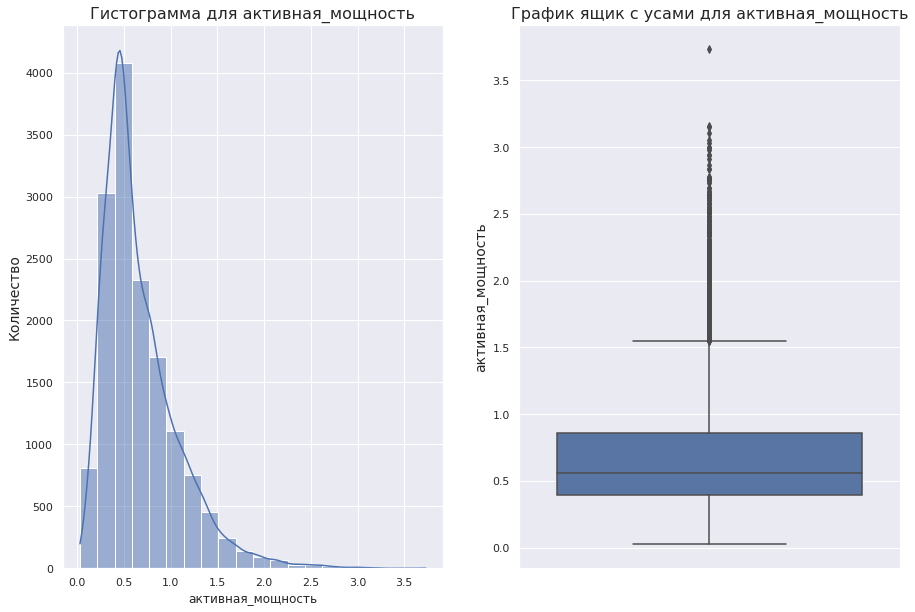

In [10]:
hist_with_box(data_arc, 'активная_мощность', None)

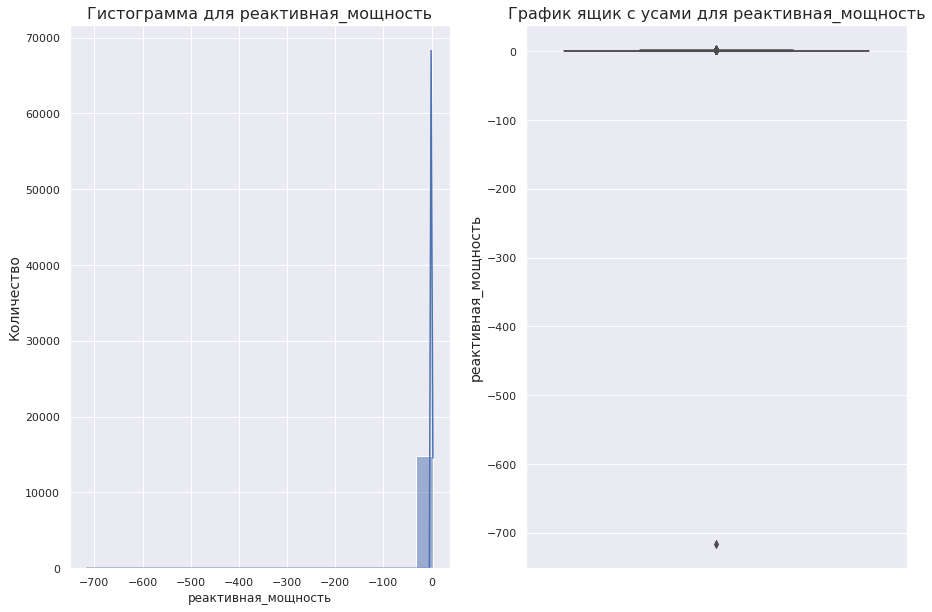

In [11]:
hist_with_box(data_arc, 'реактивная_мощность', None)

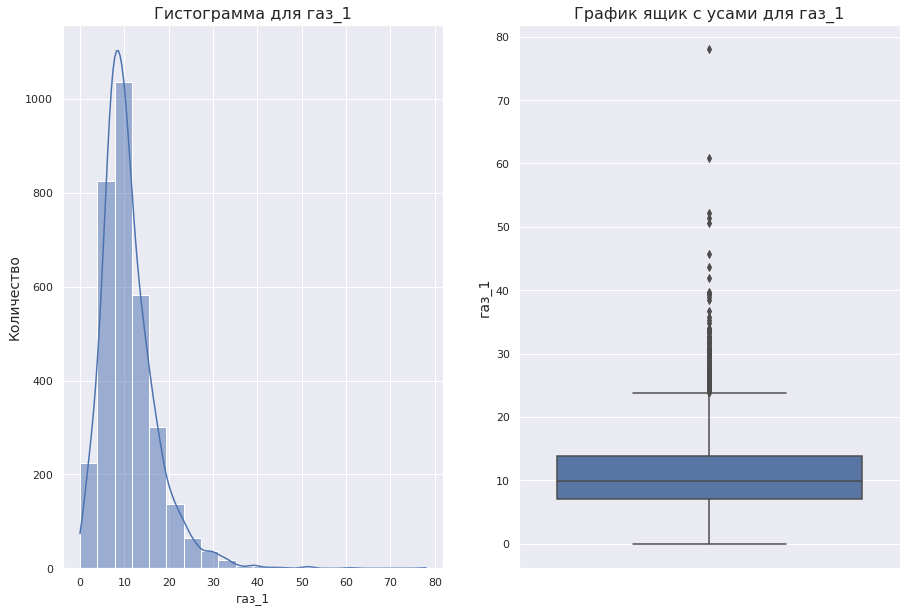

In [12]:
hist_with_box(data_gas, 'газ_1', None)

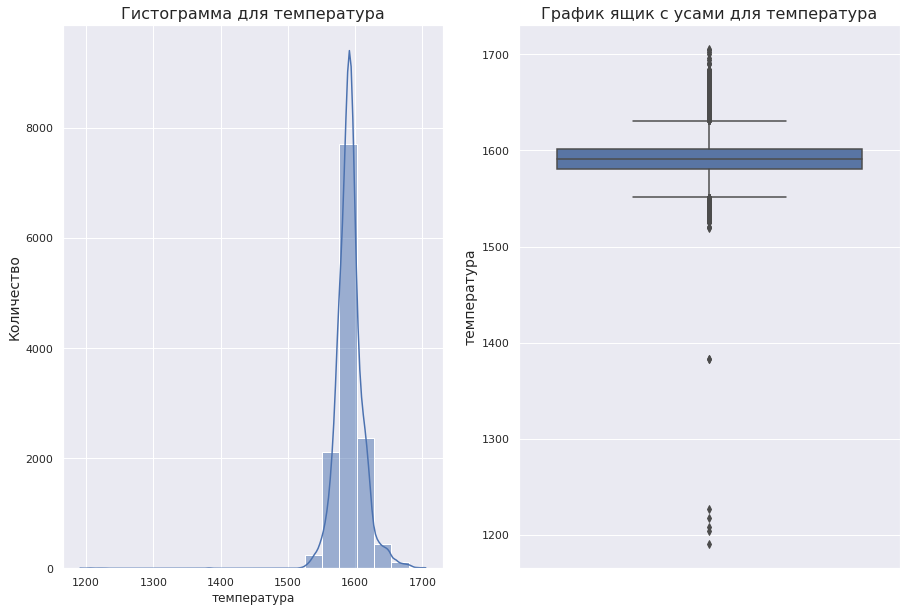

In [13]:
hist_with_box(data_temp, 'температура', None)

**Вывод:** Вывел первые 5 строк всех таблиц,так же вывел информацию о таблицах, наблюдаю большое колличество пропусков в данных и разное колличество строк.Привел название столбцов в змеиный и нижний регистр, далее вывел информацию о дубликатах,их нет, и набор статистических данных, в которых наблюдаю большой разброс.Так же вывел гистограммы и ящики с усами для некоторых столбцов,наблюдаю наличие выбросов и аномалий. 

## Предобработка данных

In [14]:
data_arc.query('реактивная_мощность < 0')

,key,начало_нагрева_дугой,конец_нагрева_дугой,активная_мощность,реактивная_мощность
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924


In [15]:
data_arc = data_arc.query('key != 2116')
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14872 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14872 non-null  int64         
 1   начало_нагрева_дугой  14872 non-null  datetime64[ns]
 2   конец_нагрева_дугой   14872 non-null  datetime64[ns]
 3   активная_мощность     14872 non-null  float64       
 4   реактивная_мощность   14872 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 697.1 KB


In [16]:
data_arc['время_нагрева'] = data_arc['конец_нагрева_дугой'] - data_arc['начало_нагрева_дугой']
data_arc['время_нагрева'] = data_arc['время_нагрева'].dt.seconds

In [17]:
data_arc_new = data_arc.groupby('key')['активная_мощность', 'реактивная_мощность', 'время_нагрева'].sum().reset_index()
data_arc_new.head()

,key,активная_мощность,реактивная_мощность,время_нагрева
0,1,4.878147,3.183241,1098
1,2,3.052598,1.998112,811
2,3,2.525882,1.599076,655
3,4,3.209250,2.060298,741
4,5,3.347173,2.252643,869


In [18]:
data_arc_new['полная_мощность'] = (data_arc_new['активная_мощность'] ** 2 + data_arc_new['реактивная_мощность'] ** 2) **0.5

In [19]:
data_arc_new['энергия'] = (data_arc_new['полная_мощность'] * data_arc_new['время_нагрева'])
data_arc_new

,key,активная_мощность,реактивная_мощность,время_нагрева,полная_мощность,энергия
0,1,4.878147,3.183241,1098,5.824889,6395.728622
1,2,3.052598,1.998112,811,3.648398,2958.850582
2,3,2.525882,1.599076,655,2.989502,1958.124109
3,4,3.209250,2.060298,741,3.813674,2825.932742
4,5,3.347173,2.252643,869,4.034596,3506.063873
...,...,...,...,...,...,...
3208,3237,3.932467,2.828459,909,4.844014,4403.209157
3209,3238,2.106529,1.681182,546,2.695151,1471.552263
3210,3239,4.666754,3.111617,1216,5.608989,6820.530675
3211,3240,2.984083,2.483267,839,3.882186,3257.153816


In [20]:
data_bulk = data_bulk[['key', 'bulk_3', 'bulk_4', 'bulk_12', 'bulk_14', 'bulk_15']]
data_bulk.head()

,key,bulk_3,bulk_4,bulk_12,bulk_14,bulk_15
0,1,NaN,43.0,206.0,150.0,154.0
1,2,NaN,73.0,206.0,149.0,154.0
2,3,NaN,34.0,205.0,152.0,153.0
3,4,NaN,81.0,207.0,153.0,154.0
4,5,NaN,78.0,203.0,151.0,152.0


In [21]:
data_wire = data_wire[['key', 'wire_1', 'wire_2']]
data_wire.head()

,key,wire_1,wire_2
0,1,60.059998,NaN
1,2,96.052315,NaN
2,3,91.160157,NaN
3,4,89.063515,NaN
4,5,89.238236,9.11456


In [22]:
data_bulk_new = data_bulk.fillna(0)
data_wire_new = data_wire.fillna(0)
display(data_bulk_new.head())
data_wire_new.head()

,key,bulk_3,bulk_4,bulk_12,bulk_14,bulk_15
0,1,0.0,43.0,206.0,150.0,154.0
1,2,0.0,73.0,206.0,149.0,154.0
2,3,0.0,34.0,205.0,152.0,153.0
3,4,0.0,81.0,207.0,153.0,154.0
4,5,0.0,78.0,203.0,151.0,152.0


,key,wire_1,wire_2
0,1,60.059998,0.00000
1,2,96.052315,0.00000
2,3,91.160157,0.00000
3,4,89.063515,0.00000
4,5,89.238236,9.11456


In [23]:
data_temp_new = data_temp.query('температура > 1500')

In [24]:
freq_temp = data_temp_new.dropna()
freq_temp = freq_temp['key'].value_counts().sort_values(ascending=True)
freq_temp.reset_index(name='freq_temp').query('freq_temp > 1').sort_values(by= 'index',ascending=True).tail()

,index,freq_temp
1008,2495,3
1414,2496,4
766,2497,2
2113,2498,5
1099,2499,3


In [25]:
data_temp_new = data_temp_new.query('key <= 2499')

In [26]:
data_temp_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12261 entries, 0 to 12266
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           12261 non-null  int64         
 1   время_замера  12261 non-null  datetime64[ns]
 2   температура   12261 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 383.2 KB


In [27]:
data_temp_final = data_temp_new.groupby(by = 'key').agg(['first', 'last']).reset_index()
data_temp_final.columns = ['key', 'первое_время_замера', 'последнее_время_замера',
                           'первая_температура', 'последняя_температура']
data_temp_final['время_между_замерами'] = data_temp_final['последнее_время_замера'] - data_temp_final['первое_время_замера']
data_temp_final['время_между_замерами'] = data_temp_final['время_между_замерами'].dt.seconds                                          
data_temp_final

,key,первое_время_замера,последнее_время_замера,первая_температура,последняя_температура,время_между_замерами
0,1,2019-05-03 11:16:18,2019-05-03 11:30:39,1571.0,1613.0,861
1,2,2019-05-03 11:37:27,2019-05-03 11:59:12,1581.0,1602.0,1305
2,3,2019-05-03 12:13:17,2019-05-03 12:34:57,1596.0,1599.0,1300
3,4,2019-05-03 12:52:57,2019-05-03 12:59:25,1601.0,1625.0,388
4,5,2019-05-03 13:23:19,2019-05-03 13:36:01,1576.0,1602.0,762
...,...,...,...,...,...,...
2472,2495,2019-08-06 00:35:45,2019-08-06 00:54:42,1570.0,1591.0,1137
2473,2496,2019-08-06 01:02:54,2019-08-06 01:29:52,1554.0,1591.0,1618
2474,2497,2019-08-06 01:41:53,2019-08-06 01:53:50,1571.0,1589.0,717
2475,2498,2019-08-06 02:03:49,2019-08-06 02:25:31,1591.0,1594.0,1302


**Вывод:** В столбце *data arc* вывел строку с (аномальной) отрицательной *реактивной мощностью* и удалил ее, далее добавил новый признак *время нагрева* в секундах(разница между началом и концом нагрева дугой), далее агрегировал данные по ключу, далее добавил новый признак *полная мощность* путем вычисления по формуле $S=\sqrt{P^{2}+Q^{2}}$:

где $P$ — активная мощность, $Q$ — реактивная мощность.

Далее добавил новый признак *энергия*, вычисляемый по формуле $W={S*T}$:

где $S$ — полная мощность, $T$ — время.   

В столбце *data bulk* оставил только те столбцы, в которых процент пропусков меньше 80%(в колличестве 5 столбцов), остальные заполнил нулями.

В столбце *data wire* оставил только те столбцы, в которых процент пропусков меньше 80%(в колличестве 2 столбцов), остальные заполнил нулями.

В столбце *data temp* удалил строки с температурой, наже 1500, так же отсортировал данные по колличеству ключей(замеров температуры) и если их меньше 2-х, то они не подойдут для предсказания и ниже удалил их. Максимальное значение ключа *2499*, и оставшееся колличество строк ровняется 12261. Далее добавил новые 3 признака *первое_время_замера*, *последнее_время_замера* и *время_между_замерами*.

## Шаг. Объединение данных

In [28]:
df_final = data_arc_new.merge(data_bulk_new, on = 'key', how  ='inner')
df_final = df_final.merge(data_gas, on = 'key', how  ='inner')
df_final = df_final.merge(data_temp_final, on = 'key', how  ='inner')
df_final = df_final.merge(data_wire_new, on = 'key', how  ='inner')

df_final.tail()                              

,key,активная_мощность,реактивная_мощность,время_нагрева,полная_мощность,энергия,bulk_3,bulk_4,bulk_12,bulk_14,bulk_15,газ_1,первое_время_замера,последнее_время_замера,первая_температура,последняя_температура,время_между_замерами,wire_1,wire_2
2323,2495,3.210690,2.360777,723,3.985197,2881.297646,21.0,0.0,256.0,129.0,223.0,7.125735,2019-08-06 00:35:45,2019-08-06 00:54:42,1570.0,1591.0,1137,89.150879,0.00000
2324,2496,4.203064,2.810185,940,5.055976,4752.617092,0.0,63.0,256.0,129.0,226.0,9.412616,2019-08-06 01:02:54,2019-08-06 01:29:52,1554.0,1591.0,1618,114.179527,0.00000
2325,2497,2.212379,1.851269,569,2.884756,1641.426283,0.0,85.0,230.0,124.0,226.0,6.271699,2019-08-06 01:41:53,2019-08-06 01:53:50,1571.0,1589.0,717,94.086723,9.04800
2326,2498,3.408725,2.355428,750,4.143362,3107.521735,90.0,0.0,206.0,129.0,207.0,14.953657,2019-08-06 02:03:49,2019-08-06 02:25:31,1591.0,1594.0,1302,118.110717,0.00000
2327,2499,4.098431,2.777865,883,4.951128,4371.846122,47.0,0.0,233.0,126.0,227.0,11.336151,2019-08-06 02:40:25,2019-08-06 03:00:28,1569.0,1603.0,1203,110.160958,50.00528


In [29]:
df_final = df_final.drop(df_final.columns[[0, 12, 13]], axis=1)
display(df_final.head())
df_final.info()

,активная_мощность,реактивная_мощность,время_нагрева,полная_мощность,энергия,bulk_3,bulk_4,bulk_12,bulk_14,bulk_15,газ_1,первая_температура,последняя_температура,время_между_замерами,wire_1,wire_2
0,4.878147,3.183241,1098,5.824889,6395.728622,0.0,43.0,206.0,150.0,154.0,29.749986,1571.0,1613.0,861,60.059998,0.00000
1,3.052598,1.998112,811,3.648398,2958.850582,0.0,73.0,206.0,149.0,154.0,12.555561,1581.0,1602.0,1305,96.052315,0.00000
2,2.525882,1.599076,655,2.989502,1958.124109,0.0,34.0,205.0,152.0,153.0,28.554793,1596.0,1599.0,1300,91.160157,0.00000
3,3.209250,2.060298,741,3.813674,2825.932742,0.0,81.0,207.0,153.0,154.0,18.841219,1601.0,1625.0,388,89.063515,0.00000
4,3.347173,2.252643,869,4.034596,3506.063873,0.0,78.0,203.0,151.0,152.0,5.413692,1576.0,1602.0,762,89.238236,9.11456


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2328 entries, 0 to 2327
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   активная_мощность      2328 non-null   float64
 1   реактивная_мощность    2328 non-null   float64
 2   время_нагрева          2328 non-null   int64  
 3   полная_мощность        2328 non-null   float64
 4   энергия                2328 non-null   float64
 5   bulk_3                 2328 non-null   float64
 6   bulk_4                 2328 non-null   float64
 7   bulk_12                2328 non-null   float64
 8   bulk_14                2328 non-null   float64
 9   bulk_15                2328 non-null   float64
 10  газ_1                  2328 non-null   float64
 11  первая_температура     2328 non-null   float64
 12  последняя_температура  2328 non-null   float64
 13  время_между_замерами   2328 non-null   int64  
 14  wire_1                 2328 non-null   float64
 15  wire

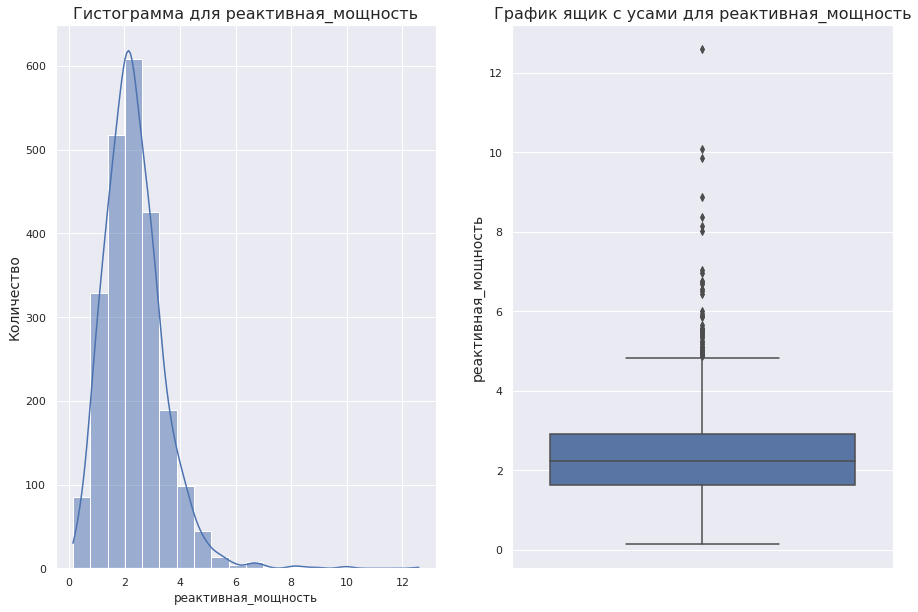

In [30]:
hist_with_box(df_final, 'реактивная_мощность', None)

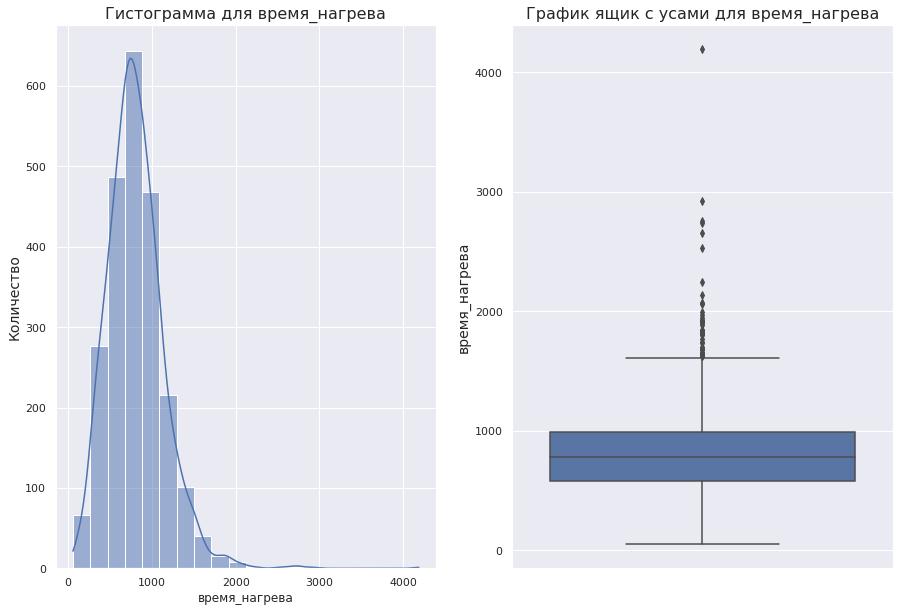

In [31]:
hist_with_box(df_final, 'время_нагрева', None)

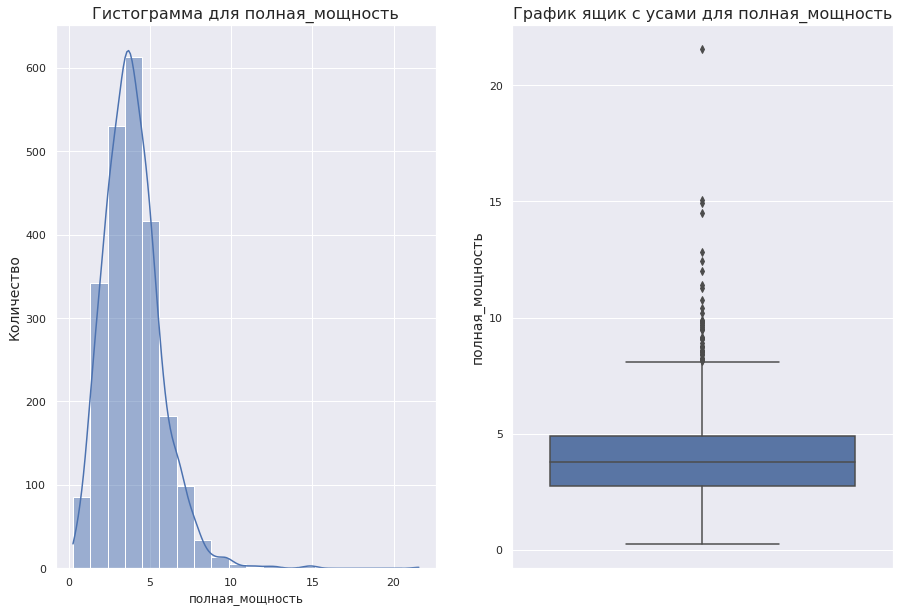

In [32]:
hist_with_box(df_final, 'полная_мощность', None)

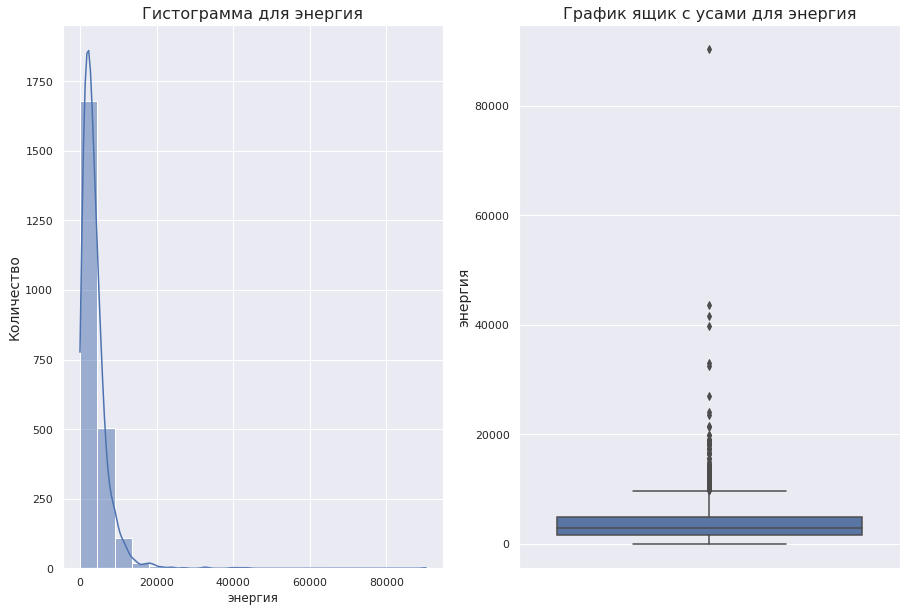

In [33]:
hist_with_box(df_final, 'энергия', None)

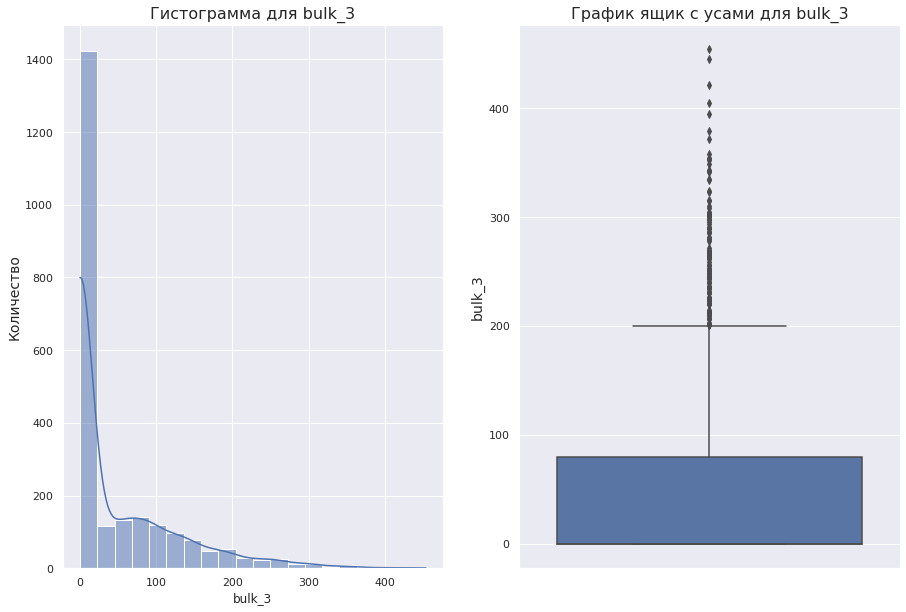

In [34]:
hist_with_box(df_final, 'bulk_3', None)

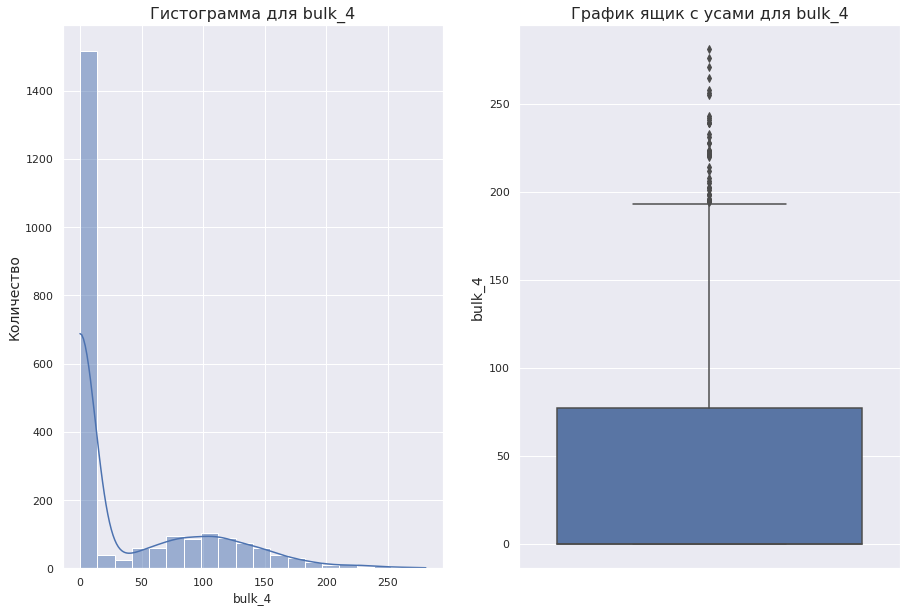

In [35]:
hist_with_box(df_final, 'bulk_4', None)

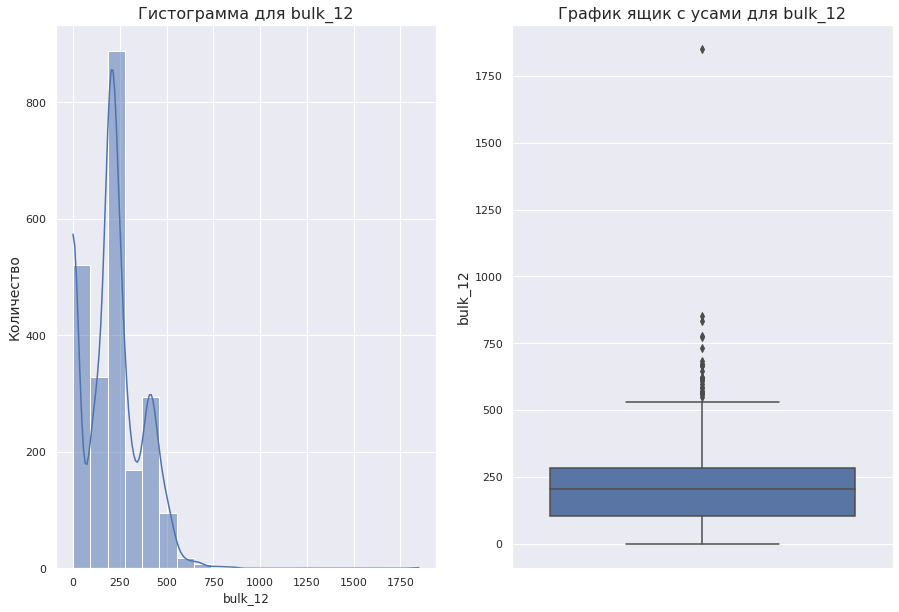

In [36]:
hist_with_box(df_final, 'bulk_12', None)

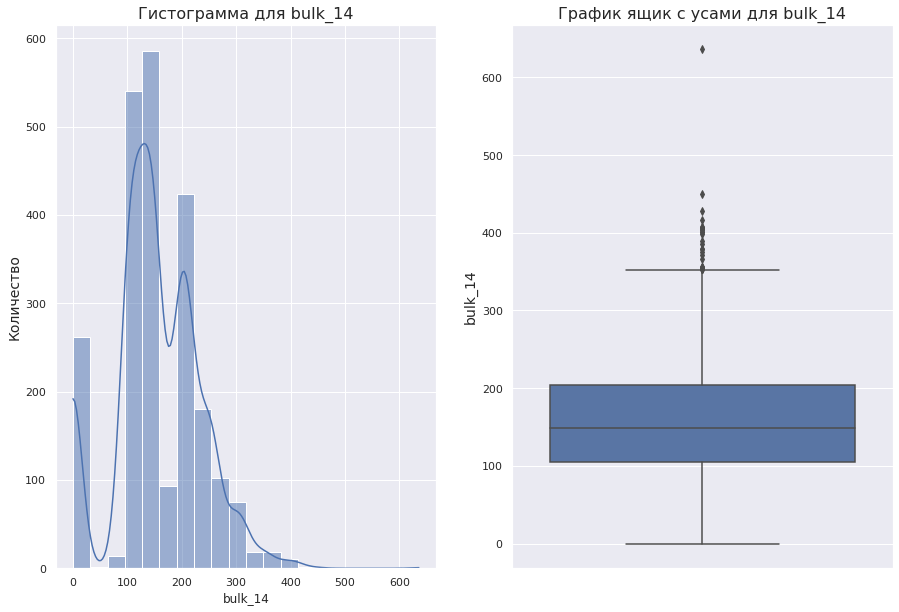

In [37]:
hist_with_box(df_final, 'bulk_14', None)

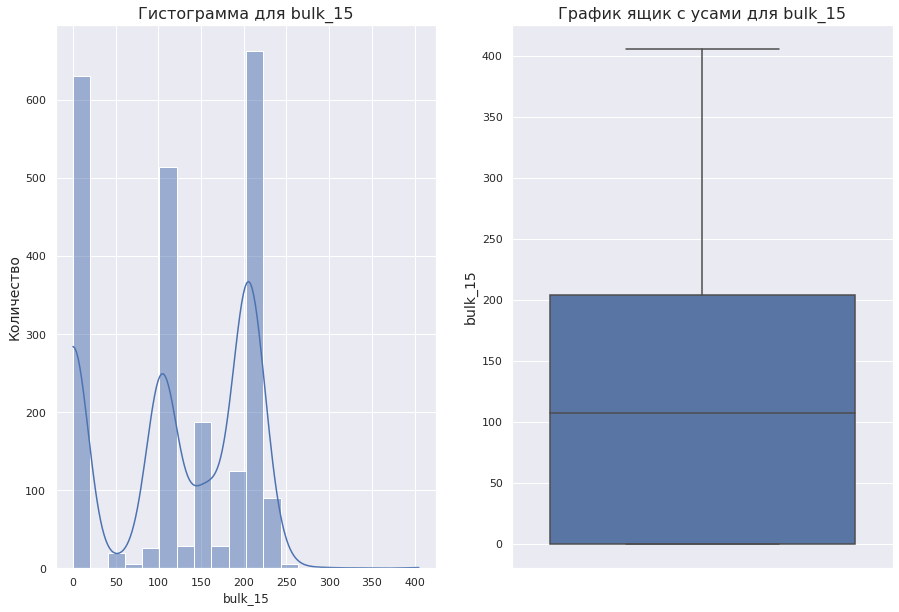

In [38]:
hist_with_box(df_final, 'bulk_15', None)

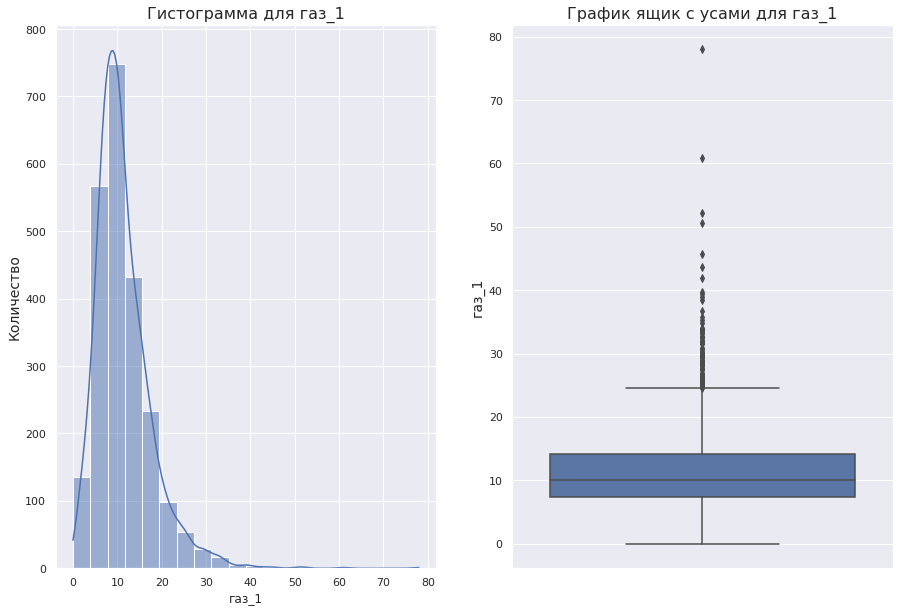

In [39]:
hist_with_box(df_final, 'газ_1', None)

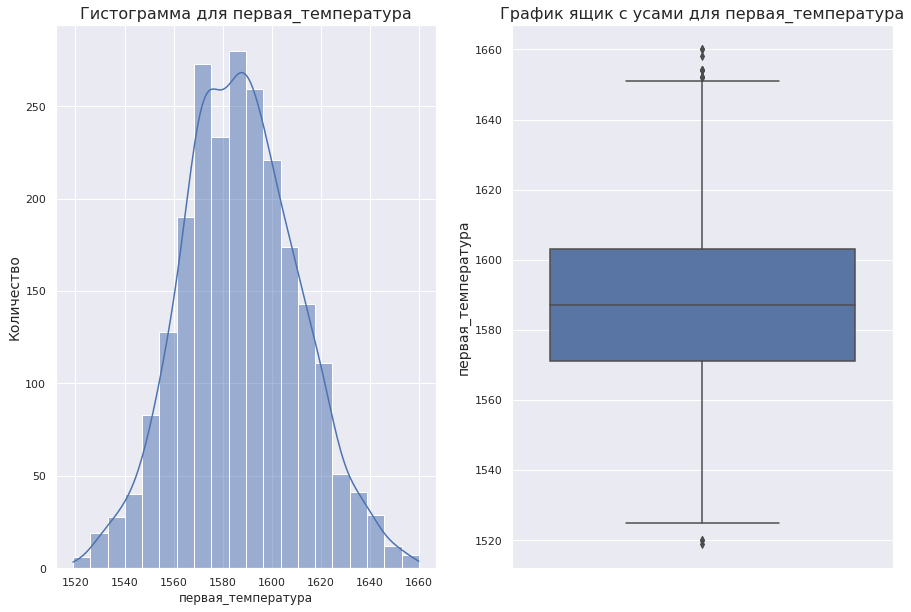

In [40]:
hist_with_box(df_final, 'первая_температура', None)

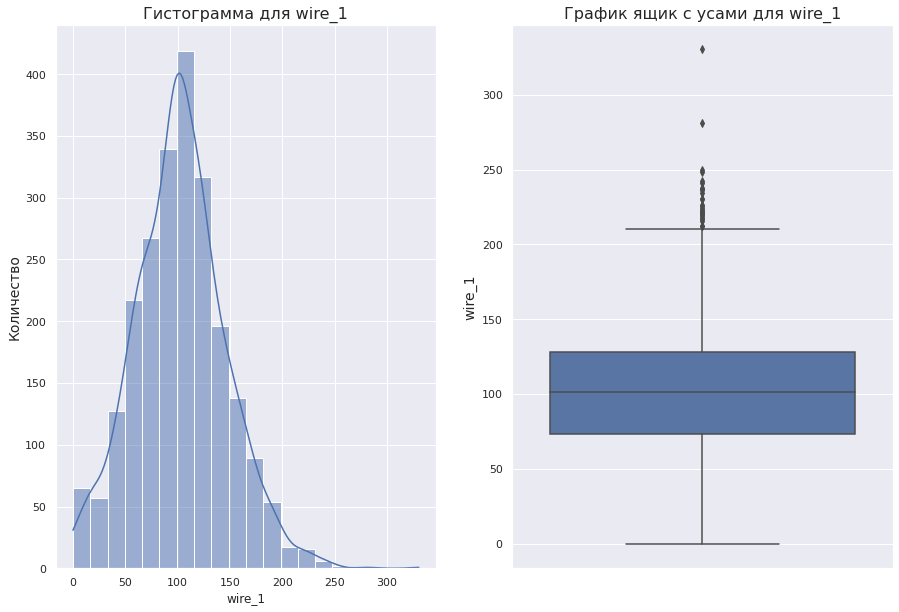

In [41]:
hist_with_box(df_final, 'wire_1', None)

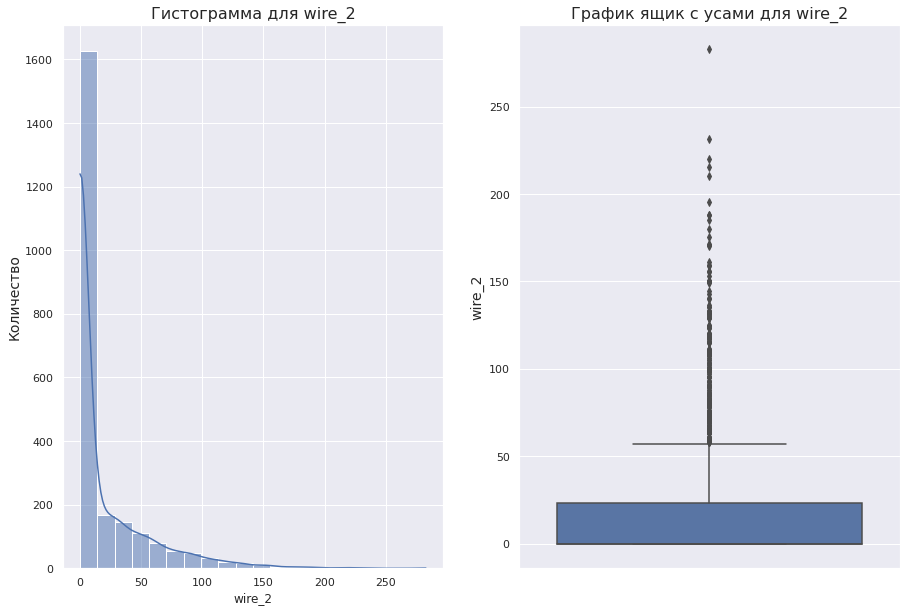

In [42]:
hist_with_box(df_final, 'wire_2', None)

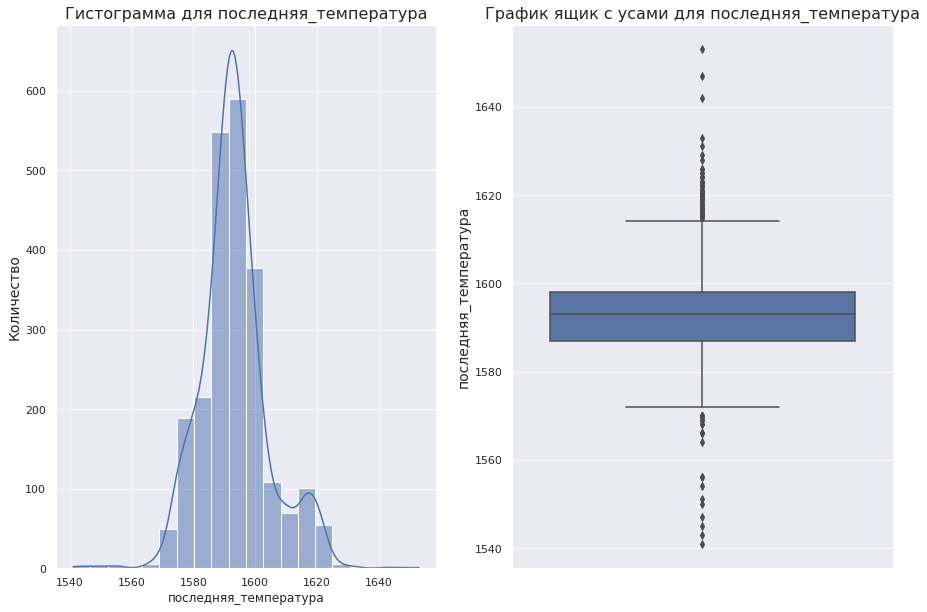

In [43]:
hist_with_box(df_final, 'последняя_температура', None)

**Вывод:** Для предсказания взял 5 таблиц и объединил их методом *merge*, получилось 2328 строк, далее удалил столбец с ключами, и с датой и временем, они больше не понадобятся. Вывел гистограммы и boxplot для всех признаков объедененной выборки

## Шаг.  Исследовательский анализ и предобработка данных объединённого датафрейма

interval columns not set, guessing: ['активная_мощность', 'реактивная_мощность', 'время_нагрева', 'полная_мощность', 'энергия', 'bulk_3', 'bulk_4', 'bulk_12', 'bulk_14', 'bulk_15', 'газ_1', 'первая_температура', 'последняя_температура', 'время_между_замерами', 'wire_1', 'wire_2']


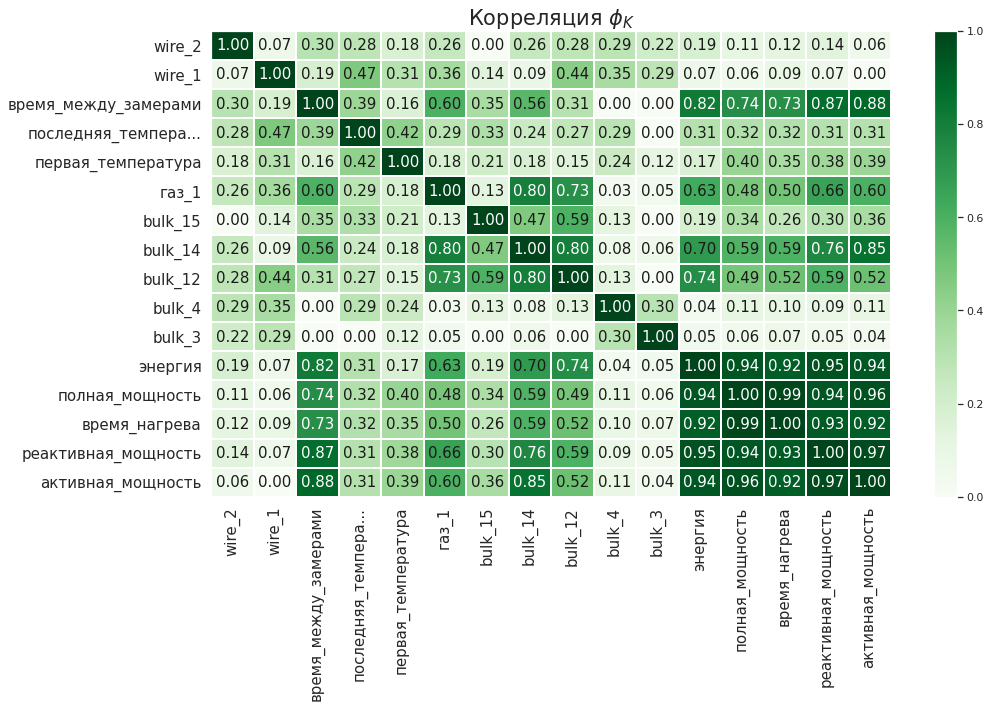

In [44]:
df_phik = df_final

interval_cols = ['первая_температура', 'последняя_температура', 'время_между_замерами',
                 'активная_мощность', 'реактивная_мощность', 'время_нагрева', 'полная_мощность']

phik_overview = df_phik.phik_matrix()

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'Корреляция $\phi_K$',
    fontsize_factor=1.5,
    figsize=(15, 10)
)

In [45]:
df_final.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
активная_мощность,2328.0,3.153009,1.425340,0.186226,2.173710,3.028796,3.920723,17.496497
реактивная_мощность,2328.0,2.351686,1.081628,0.158247,1.627043,2.235148,2.915289,12.587990
время_нагрева,2328.0,807.808419,340.823100,57.000000,581.000000,778.000000,993.000000,4189.000000
полная_мощность,2328.0,3.939248,1.776432,0.257637,2.734664,3.773508,4.876028,21.554231
энергия,2328.0,3776.943754,3879.357798,15.158096,1595.558091,2929.348779,4828.431690,90290.674886
bulk_3,2328.0,47.368557,75.320213,0.000000,0.000000,0.000000,80.000000,454.000000
bulk_4,2328.0,37.319588,58.650737,0.000000,0.000000,0.000000,77.250000,281.000000
bulk_12,2328.0,208.505155,157.036569,0.000000,105.000000,206.000000,282.250000,1849.000000
bulk_14,2328.0,153.834622,81.416698,0.000000,105.000000,149.000000,204.000000,636.000000
bulk_15,2328.0,120.004296,84.622085,0.000000,0.000000,107.000000,204.000000,405.000000


**Вывод:** Провел корреляционный анализ и вывел heatmap, есть сильная зависимость(больше 0.9) у столбцов, которые были включены в формулы,а именно у столбца 'энергия' с 'активная_мощность', 'реактивная_мощность', 'время_нагрева', 'полная_мощность', они будут удалены при обучении линейной регрессии. Так же зависимсть более 0.8 между признаком 'время_между_замерами' и 'активная_мощность', 'реактивная_мощность', между 'bulk_14' и 'активная_мощность', 'bulk_12', 'газ_1'.

## Шаг. Подготовка данных

In [46]:
X = df_final.drop('последняя_температура', axis=1)
y = df_final['последняя_температура']

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    random_state=RANDOM_STATE, 
    test_size=TEST_SIZE
) 

for i in [X_train, X_test, y_train, y_test]:
    print(i.shape)

(1746, 15)
(582, 15)
(1746,)
(582,)


**Вывод:** Выделил признаки и целевой признак и разбил выборку на *train* и *test* в соотношении 75/25. Размер тестовой выборки получился 1746 строк, а тренировочной 582.

## Шаг. Обучение моделей машинного обучения

### Обучение CatBoostRegressor

In [47]:
%%time

model_cbr = CatBoostRegressor(random_state=RANDOM_STATE)

parameters = {'depth' : [6,8,10],
              'learning_rate' : [0.01, 0.05, 0.1],
              'iterations'    : [10, 50, 100]
              }

grid_cbr = GridSearchCV(estimator=model_cbr, 
                        param_grid = parameters, 
                        cv = 5, n_jobs=-1, 
                        scoring='neg_mean_absolute_error'
)

grid_cbr.fit(X_train, y_train)

0:	learn: 10.9493623	total: 52.1ms	remaining: 469ms
1:	learn: 10.9260037	total: 55.9ms	remaining: 224ms
2:	learn: 10.8969690	total: 59.4ms	remaining: 139ms
3:	learn: 10.8669894	total: 62.7ms	remaining: 94ms
4:	learn: 10.8374093	total: 65.8ms	remaining: 65.8ms
5:	learn: 10.8077557	total: 69ms	remaining: 46ms
6:	learn: 10.7782729	total: 72.2ms	remaining: 30.9ms
7:	learn: 10.7486374	total: 75.8ms	remaining: 18.9ms
8:	learn: 10.7219570	total: 79.2ms	remaining: 8.79ms
9:	learn: 10.6969006	total: 82.4ms	remaining: 0us
0:	learn: 10.8918067	total: 3.74ms	remaining: 33.7ms
1:	learn: 10.8645662	total: 7.29ms	remaining: 29.2ms
2:	learn: 10.8399848	total: 10.8ms	remaining: 25.3ms
3:	learn: 10.8147649	total: 14.4ms	remaining: 21.6ms
4:	learn: 10.7857498	total: 17.8ms	remaining: 17.8ms
5:	learn: 10.7598322	total: 21.2ms	remaining: 14.1ms
6:	learn: 10.7343108	total: 24.8ms	remaining: 10.6ms
7:	learn: 10.7094284	total: 28.4ms	remaining: 7.11ms
8:	learn: 10.6846470	total: 31.9ms	remaining: 3.55ms
9:	le

0:	learn: 10.8918067	total: 3.7ms	remaining: 181ms
1:	learn: 10.8645662	total: 7.1ms	remaining: 170ms
2:	learn: 10.8399848	total: 10.6ms	remaining: 166ms
3:	learn: 10.8147649	total: 14.1ms	remaining: 163ms
4:	learn: 10.7857498	total: 17.9ms	remaining: 161ms
5:	learn: 10.7598322	total: 21.4ms	remaining: 157ms
6:	learn: 10.7343108	total: 25ms	remaining: 154ms
7:	learn: 10.7094284	total: 28.5ms	remaining: 150ms
8:	learn: 10.6846470	total: 32.1ms	remaining: 146ms
9:	learn: 10.6597581	total: 35.4ms	remaining: 141ms
10:	learn: 10.6309511	total: 38.7ms	remaining: 137ms
11:	learn: 10.6065431	total: 42.3ms	remaining: 134ms
12:	learn: 10.5827309	total: 45.6ms	remaining: 130ms
13:	learn: 10.5536234	total: 48.7ms	remaining: 125ms
14:	learn: 10.5303636	total: 51.9ms	remaining: 121ms
15:	learn: 10.5051352	total: 55.4ms	remaining: 118ms
16:	learn: 10.4748352	total: 58.7ms	remaining: 114ms
17:	learn: 10.4536326	total: 61.9ms	remaining: 110ms
18:	learn: 10.4277992	total: 65.3ms	remaining: 107ms
19:	lea

0:	learn: 10.8265697	total: 3.78ms	remaining: 185ms
1:	learn: 10.6609458	total: 7.47ms	remaining: 179ms
2:	learn: 10.5319539	total: 11.2ms	remaining: 175ms
3:	learn: 10.4027583	total: 14.9ms	remaining: 171ms
4:	learn: 10.2794803	total: 18.8ms	remaining: 169ms
5:	learn: 10.1626277	total: 22.4ms	remaining: 165ms
6:	learn: 10.0481770	total: 26.1ms	remaining: 161ms
7:	learn: 9.9379164	total: 30.2ms	remaining: 159ms
8:	learn: 9.8474060	total: 33.6ms	remaining: 153ms
9:	learn: 9.7613192	total: 37.3ms	remaining: 149ms
10:	learn: 9.6623617	total: 41ms	remaining: 145ms
11:	learn: 9.5730811	total: 44.7ms	remaining: 142ms
12:	learn: 9.4831857	total: 48.3ms	remaining: 138ms
13:	learn: 9.3955734	total: 51.9ms	remaining: 133ms
14:	learn: 9.3211195	total: 55.3ms	remaining: 129ms
15:	learn: 9.2477372	total: 58.6ms	remaining: 125ms
16:	learn: 9.1686972	total: 62.3ms	remaining: 121ms
17:	learn: 9.1070438	total: 65.8ms	remaining: 117ms
18:	learn: 9.0315162	total: 69.3ms	remaining: 113ms
19:	learn: 8.9769

0:	learn: 10.8995655	total: 3.93ms	remaining: 192ms
1:	learn: 10.7695832	total: 7.54ms	remaining: 181ms
2:	learn: 10.6409227	total: 11.2ms	remaining: 176ms
3:	learn: 10.5324376	total: 14.9ms	remaining: 171ms
4:	learn: 10.4051203	total: 18.5ms	remaining: 166ms
5:	learn: 10.3069465	total: 21.9ms	remaining: 160ms
6:	learn: 10.2094856	total: 26ms	remaining: 160ms
7:	learn: 10.1103016	total: 29.8ms	remaining: 156ms
8:	learn: 10.0075040	total: 33.6ms	remaining: 153ms
9:	learn: 9.9205243	total: 37.2ms	remaining: 149ms
10:	learn: 9.8380693	total: 40.7ms	remaining: 144ms
11:	learn: 9.7481950	total: 44.6ms	remaining: 141ms
12:	learn: 9.6752068	total: 48.2ms	remaining: 137ms
13:	learn: 9.6005620	total: 51.8ms	remaining: 133ms
14:	learn: 9.5229760	total: 55.2ms	remaining: 129ms
15:	learn: 9.4524657	total: 58.6ms	remaining: 125ms
16:	learn: 9.3817790	total: 62.7ms	remaining: 122ms
17:	learn: 9.3255832	total: 66.4ms	remaining: 118ms
18:	learn: 9.2620091	total: 69.7ms	remaining: 114ms
19:	learn: 9.20

44:	learn: 7.0246550	total: 187ms	remaining: 20.8ms
45:	learn: 6.9998806	total: 191ms	remaining: 16.6ms
46:	learn: 6.9751466	total: 195ms	remaining: 12.4ms
47:	learn: 6.9414234	total: 199ms	remaining: 8.27ms
48:	learn: 6.9186974	total: 203ms	remaining: 4.15ms
49:	learn: 6.8826889	total: 207ms	remaining: 0us
0:	learn: 10.6810816	total: 3.66ms	remaining: 180ms
1:	learn: 10.3994552	total: 7.17ms	remaining: 172ms
2:	learn: 10.1778106	total: 11ms	remaining: 173ms
3:	learn: 9.9490304	total: 14.7ms	remaining: 170ms
4:	learn: 9.7632482	total: 18ms	remaining: 162ms
5:	learn: 9.5995771	total: 22ms	remaining: 162ms
6:	learn: 9.4359168	total: 26.1ms	remaining: 161ms
7:	learn: 9.3234916	total: 29.7ms	remaining: 156ms
8:	learn: 9.1929640	total: 33.1ms	remaining: 151ms
9:	learn: 9.0790071	total: 36.7ms	remaining: 147ms
10:	learn: 8.9570737	total: 41ms	remaining: 146ms
11:	learn: 8.8395705	total: 45.1ms	remaining: 143ms
12:	learn: 8.7392300	total: 48.8ms	remaining: 139ms
13:	learn: 8.6301209	total: 52

97:	learn: 9.0521720	total: 353ms	remaining: 7.21ms
98:	learn: 9.0379352	total: 357ms	remaining: 3.61ms
99:	learn: 9.0241607	total: 361ms	remaining: 0us
0:	learn: 10.8918067	total: 3.59ms	remaining: 355ms
1:	learn: 10.8645662	total: 7.13ms	remaining: 349ms
2:	learn: 10.8399848	total: 10.8ms	remaining: 348ms
3:	learn: 10.8147649	total: 14.1ms	remaining: 338ms
4:	learn: 10.7857498	total: 17.5ms	remaining: 332ms
5:	learn: 10.7598322	total: 20.9ms	remaining: 327ms
6:	learn: 10.7343108	total: 24.2ms	remaining: 322ms
7:	learn: 10.7094284	total: 27.9ms	remaining: 321ms
8:	learn: 10.6846470	total: 31.7ms	remaining: 321ms
9:	learn: 10.6597581	total: 35.4ms	remaining: 318ms
10:	learn: 10.6309511	total: 39.5ms	remaining: 320ms
11:	learn: 10.6065431	total: 45.4ms	remaining: 333ms
12:	learn: 10.5827309	total: 49.1ms	remaining: 328ms
13:	learn: 10.5536234	total: 52.5ms	remaining: 323ms
14:	learn: 10.5303636	total: 56ms	remaining: 317ms
15:	learn: 10.5051352	total: 59.4ms	remaining: 312ms
16:	learn: 

0:	learn: 10.9274795	total: 3.5ms	remaining: 347ms
1:	learn: 10.8960305	total: 7.05ms	remaining: 345ms
2:	learn: 10.8688018	total: 10.4ms	remaining: 337ms
3:	learn: 10.8381246	total: 13.7ms	remaining: 329ms
4:	learn: 10.8094785	total: 17.2ms	remaining: 326ms
5:	learn: 10.7812761	total: 20.5ms	remaining: 321ms
6:	learn: 10.7559484	total: 23.6ms	remaining: 314ms
7:	learn: 10.7301967	total: 27ms	remaining: 311ms
8:	learn: 10.7035796	total: 30.5ms	remaining: 308ms
9:	learn: 10.6790093	total: 33.8ms	remaining: 304ms
10:	learn: 10.6516599	total: 37.3ms	remaining: 302ms
11:	learn: 10.6249163	total: 40.7ms	remaining: 299ms
12:	learn: 10.6019416	total: 44ms	remaining: 294ms
13:	learn: 10.5737311	total: 47.6ms	remaining: 293ms
14:	learn: 10.5480826	total: 51.5ms	remaining: 292ms
15:	learn: 10.5205418	total: 55ms	remaining: 289ms
16:	learn: 10.4940794	total: 58.2ms	remaining: 284ms
17:	learn: 10.4715780	total: 61.4ms	remaining: 279ms
18:	learn: 10.4472063	total: 64.8ms	remaining: 276ms
19:	learn:

0:	learn: 10.8265697	total: 3.73ms	remaining: 369ms
1:	learn: 10.6609458	total: 7.38ms	remaining: 362ms
2:	learn: 10.5319539	total: 10.7ms	remaining: 346ms
3:	learn: 10.4027583	total: 14.1ms	remaining: 338ms
4:	learn: 10.2794803	total: 17.2ms	remaining: 328ms
5:	learn: 10.1626277	total: 20.6ms	remaining: 322ms
6:	learn: 10.0481770	total: 24ms	remaining: 319ms
7:	learn: 9.9379164	total: 27.3ms	remaining: 314ms
8:	learn: 9.8474060	total: 30.5ms	remaining: 308ms
9:	learn: 9.7613192	total: 33.7ms	remaining: 304ms
10:	learn: 9.6623617	total: 37ms	remaining: 299ms
11:	learn: 9.5730811	total: 40.5ms	remaining: 297ms
12:	learn: 9.4831857	total: 44ms	remaining: 295ms
13:	learn: 9.3955734	total: 47.3ms	remaining: 291ms
14:	learn: 9.3211195	total: 50.8ms	remaining: 288ms
15:	learn: 9.2477372	total: 54.1ms	remaining: 284ms
16:	learn: 9.1686972	total: 57.8ms	remaining: 282ms
17:	learn: 9.1070438	total: 61.1ms	remaining: 278ms
18:	learn: 9.0315162	total: 64.7ms	remaining: 276ms
19:	learn: 8.9769000	

0:	learn: 10.8720076	total: 3.36ms	remaining: 333ms
1:	learn: 10.7283797	total: 6.96ms	remaining: 341ms
2:	learn: 10.5935940	total: 10.7ms	remaining: 345ms
3:	learn: 10.4875085	total: 14.1ms	remaining: 339ms
4:	learn: 10.3609850	total: 17.7ms	remaining: 336ms
5:	learn: 10.2394964	total: 21.2ms	remaining: 332ms
6:	learn: 10.1291244	total: 24.9ms	remaining: 331ms
7:	learn: 10.0195184	total: 28.7ms	remaining: 330ms
8:	learn: 9.9232903	total: 32.1ms	remaining: 325ms
9:	learn: 9.8283605	total: 35.7ms	remaining: 322ms
10:	learn: 9.7308426	total: 39.1ms	remaining: 316ms
11:	learn: 9.6374019	total: 42.3ms	remaining: 310ms
12:	learn: 9.5500815	total: 45.8ms	remaining: 306ms
13:	learn: 9.4535187	total: 49.8ms	remaining: 306ms
14:	learn: 9.3784906	total: 53.2ms	remaining: 302ms
15:	learn: 9.3042170	total: 56.4ms	remaining: 296ms
16:	learn: 9.2321234	total: 59.8ms	remaining: 292ms
17:	learn: 9.1719698	total: 63.1ms	remaining: 288ms
18:	learn: 9.1085519	total: 66.7ms	remaining: 284ms
19:	learn: 9.0

0:	learn: 10.8995655	total: 3.92ms	remaining: 389ms
1:	learn: 10.7695832	total: 7.72ms	remaining: 378ms
2:	learn: 10.6409227	total: 11.2ms	remaining: 363ms
3:	learn: 10.5324376	total: 15ms	remaining: 361ms
4:	learn: 10.4051203	total: 18.8ms	remaining: 357ms
5:	learn: 10.3069465	total: 22.4ms	remaining: 351ms
6:	learn: 10.2094856	total: 27.7ms	remaining: 368ms
7:	learn: 10.1103016	total: 33.3ms	remaining: 383ms
8:	learn: 10.0075040	total: 38.7ms	remaining: 391ms
9:	learn: 9.9205243	total: 44.9ms	remaining: 404ms
10:	learn: 9.8380693	total: 50.6ms	remaining: 409ms
11:	learn: 9.7481950	total: 56.3ms	remaining: 413ms
12:	learn: 9.6752068	total: 61.9ms	remaining: 414ms
13:	learn: 9.6005620	total: 67ms	remaining: 412ms
14:	learn: 9.5229760	total: 72.3ms	remaining: 410ms
15:	learn: 9.4524657	total: 75.9ms	remaining: 399ms
16:	learn: 9.3817790	total: 81.1ms	remaining: 396ms
17:	learn: 9.3255832	total: 85ms	remaining: 387ms
18:	learn: 9.2620091	total: 89ms	remaining: 379ms
19:	learn: 9.2035311	

99:	learn: 5.7228040	total: 372ms	remaining: 0us
0:	learn: 10.6865295	total: 4.04ms	remaining: 400ms
1:	learn: 10.4348805	total: 7.88ms	remaining: 386ms
2:	learn: 10.2246126	total: 11.5ms	remaining: 373ms
3:	learn: 10.0023648	total: 14.9ms	remaining: 359ms
4:	learn: 9.8117437	total: 18.7ms	remaining: 355ms
5:	learn: 9.6207321	total: 22.4ms	remaining: 352ms
6:	learn: 9.4719849	total: 26.1ms	remaining: 347ms
7:	learn: 9.3181558	total: 30.2ms	remaining: 347ms
8:	learn: 9.1675865	total: 33.4ms	remaining: 338ms
9:	learn: 9.0103507	total: 36.9ms	remaining: 332ms
10:	learn: 8.8688511	total: 40.3ms	remaining: 326ms
11:	learn: 8.7614267	total: 43.7ms	remaining: 321ms
12:	learn: 8.6622343	total: 47.5ms	remaining: 318ms
13:	learn: 8.5505492	total: 51.3ms	remaining: 315ms
14:	learn: 8.4745322	total: 55.1ms	remaining: 312ms
15:	learn: 8.3956454	total: 58.6ms	remaining: 308ms
16:	learn: 8.2986766	total: 62ms	remaining: 303ms
17:	learn: 8.2363494	total: 65.5ms	remaining: 299ms
18:	learn: 8.1820626	to

0:	learn: 10.6810816	total: 4.94ms	remaining: 489ms
1:	learn: 10.3994552	total: 9.71ms	remaining: 476ms
2:	learn: 10.1778106	total: 14.8ms	remaining: 478ms
3:	learn: 9.9490304	total: 20.1ms	remaining: 482ms
4:	learn: 9.7632482	total: 25.2ms	remaining: 479ms
5:	learn: 9.5995771	total: 30.6ms	remaining: 480ms
6:	learn: 9.4359168	total: 36.1ms	remaining: 480ms
7:	learn: 9.3234916	total: 41.3ms	remaining: 475ms
8:	learn: 9.1929640	total: 46.3ms	remaining: 469ms
9:	learn: 9.0790071	total: 50ms	remaining: 450ms
10:	learn: 8.9570737	total: 53.4ms	remaining: 432ms
11:	learn: 8.8395705	total: 56.9ms	remaining: 417ms
12:	learn: 8.7392300	total: 60.3ms	remaining: 404ms
13:	learn: 8.6301209	total: 65.2ms	remaining: 401ms
14:	learn: 8.5271053	total: 69.6ms	remaining: 395ms
15:	learn: 8.4490344	total: 75.5ms	remaining: 396ms
16:	learn: 8.3597541	total: 80.6ms	remaining: 393ms
17:	learn: 8.2924728	total: 84.4ms	remaining: 385ms
18:	learn: 8.2205206	total: 88.8ms	remaining: 379ms
19:	learn: 8.1559102	

0:	learn: 10.9443887	total: 18.4ms	remaining: 166ms
1:	learn: 10.9132717	total: 29.7ms	remaining: 119ms
2:	learn: 10.8788606	total: 40.6ms	remaining: 94.7ms
3:	learn: 10.8462340	total: 51.4ms	remaining: 77ms
4:	learn: 10.8132621	total: 61.7ms	remaining: 61.7ms
5:	learn: 10.7818502	total: 72.9ms	remaining: 48.6ms
6:	learn: 10.7488744	total: 84.2ms	remaining: 36.1ms
7:	learn: 10.7174898	total: 95.3ms	remaining: 23.8ms
8:	learn: 10.6845652	total: 107ms	remaining: 11.9ms
9:	learn: 10.6572687	total: 117ms	remaining: 0us
0:	learn: 10.8884797	total: 12ms	remaining: 108ms
1:	learn: 10.8575390	total: 23.3ms	remaining: 93ms
2:	learn: 10.8247759	total: 34.1ms	remaining: 79.7ms
3:	learn: 10.7919408	total: 44.9ms	remaining: 67.3ms
4:	learn: 10.7588302	total: 56.1ms	remaining: 56.1ms
5:	learn: 10.7310781	total: 67.4ms	remaining: 44.9ms
6:	learn: 10.7000282	total: 79.1ms	remaining: 33.9ms
7:	learn: 10.6648976	total: 91ms	remaining: 22.8ms
8:	learn: 10.6351581	total: 103ms	remaining: 11.4ms
9:	learn: 

18:	learn: 10.4089454	total: 212ms	remaining: 346ms
19:	learn: 10.3782879	total: 223ms	remaining: 335ms
20:	learn: 10.3519045	total: 234ms	remaining: 323ms
21:	learn: 10.3254602	total: 245ms	remaining: 312ms
22:	learn: 10.2955584	total: 257ms	remaining: 302ms
23:	learn: 10.2653103	total: 269ms	remaining: 291ms
24:	learn: 10.2375189	total: 280ms	remaining: 280ms
25:	learn: 10.2113268	total: 291ms	remaining: 268ms
26:	learn: 10.1841040	total: 302ms	remaining: 257ms
27:	learn: 10.1567340	total: 312ms	remaining: 245ms
28:	learn: 10.1304409	total: 323ms	remaining: 234ms
29:	learn: 10.1067670	total: 334ms	remaining: 222ms
30:	learn: 10.0833522	total: 344ms	remaining: 211ms
31:	learn: 10.0580104	total: 355ms	remaining: 200ms
32:	learn: 10.0354944	total: 365ms	remaining: 188ms
33:	learn: 10.0158508	total: 376ms	remaining: 177ms
34:	learn: 9.9945376	total: 386ms	remaining: 165ms
35:	learn: 9.9700730	total: 397ms	remaining: 155ms
36:	learn: 9.9471080	total: 409ms	remaining: 144ms
37:	learn: 9.92

36:	learn: 9.9464602	total: 405ms	remaining: 142ms
37:	learn: 9.9256520	total: 416ms	remaining: 132ms
38:	learn: 9.9033948	total: 427ms	remaining: 120ms
39:	learn: 9.8838417	total: 437ms	remaining: 109ms
40:	learn: 9.8622217	total: 449ms	remaining: 98.5ms
41:	learn: 9.8427589	total: 460ms	remaining: 87.7ms
42:	learn: 9.8194916	total: 471ms	remaining: 76.7ms
43:	learn: 9.7999950	total: 482ms	remaining: 65.7ms
44:	learn: 9.7794846	total: 492ms	remaining: 54.7ms
45:	learn: 9.7561937	total: 504ms	remaining: 43.8ms
46:	learn: 9.7334658	total: 515ms	remaining: 32.9ms
47:	learn: 9.7141671	total: 527ms	remaining: 21.9ms
48:	learn: 9.6904483	total: 538ms	remaining: 11ms
49:	learn: 9.6661055	total: 549ms	remaining: 0us
0:	learn: 10.9962015	total: 12.8ms	remaining: 625ms
1:	learn: 10.9685591	total: 25.1ms	remaining: 603ms
2:	learn: 10.9354627	total: 37.3ms	remaining: 584ms
3:	learn: 10.9048874	total: 50.8ms	remaining: 584ms
4:	learn: 10.8747192	total: 62.7ms	remaining: 564ms
5:	learn: 10.8475876	

0:	learn: 10.8552111	total: 10.8ms	remaining: 529ms
1:	learn: 10.7060092	total: 22.2ms	remaining: 532ms
2:	learn: 10.5520706	total: 34.3ms	remaining: 538ms
3:	learn: 10.4166202	total: 45.6ms	remaining: 524ms
4:	learn: 10.2673353	total: 56.4ms	remaining: 508ms
5:	learn: 10.1519539	total: 67.3ms	remaining: 494ms
6:	learn: 10.0203049	total: 78.1ms	remaining: 480ms
7:	learn: 9.8891661	total: 89.1ms	remaining: 468ms
8:	learn: 9.7697009	total: 100ms	remaining: 457ms
9:	learn: 9.6646495	total: 111ms	remaining: 445ms
10:	learn: 9.5616687	total: 122ms	remaining: 431ms
11:	learn: 9.4662328	total: 133ms	remaining: 421ms
12:	learn: 9.3771591	total: 144ms	remaining: 409ms
13:	learn: 9.2772568	total: 155ms	remaining: 398ms
14:	learn: 9.1828695	total: 166ms	remaining: 387ms
15:	learn: 9.1076067	total: 176ms	remaining: 375ms
16:	learn: 9.0324547	total: 187ms	remaining: 363ms
17:	learn: 8.9479915	total: 197ms	remaining: 351ms
18:	learn: 8.8625682	total: 208ms	remaining: 339ms
19:	learn: 8.7713125	total

17:	learn: 7.8740294	total: 204ms	remaining: 363ms
18:	learn: 7.7861607	total: 217ms	remaining: 353ms
19:	learn: 7.7030106	total: 228ms	remaining: 342ms
20:	learn: 7.6241607	total: 239ms	remaining: 330ms
21:	learn: 7.5544395	total: 250ms	remaining: 319ms
22:	learn: 7.4905057	total: 261ms	remaining: 307ms
23:	learn: 7.4092788	total: 272ms	remaining: 295ms
24:	learn: 7.3321244	total: 283ms	remaining: 283ms
25:	learn: 7.2592906	total: 294ms	remaining: 272ms
26:	learn: 7.2000785	total: 306ms	remaining: 260ms
27:	learn: 7.1200048	total: 317ms	remaining: 249ms
28:	learn: 7.0751149	total: 327ms	remaining: 237ms
29:	learn: 7.0058581	total: 339ms	remaining: 226ms
30:	learn: 6.9600488	total: 350ms	remaining: 215ms
31:	learn: 6.9161178	total: 361ms	remaining: 203ms
32:	learn: 6.8664575	total: 372ms	remaining: 192ms
33:	learn: 6.8090578	total: 383ms	remaining: 180ms
34:	learn: 6.7702609	total: 394ms	remaining: 169ms
35:	learn: 6.7235423	total: 405ms	remaining: 158ms
36:	learn: 6.6725553	total: 417

34:	learn: 6.7799437	total: 414ms	remaining: 178ms
35:	learn: 6.7290265	total: 428ms	remaining: 166ms
36:	learn: 6.6741352	total: 439ms	remaining: 154ms
37:	learn: 6.6326413	total: 453ms	remaining: 143ms
38:	learn: 6.5816295	total: 465ms	remaining: 131ms
39:	learn: 6.5383521	total: 476ms	remaining: 119ms
40:	learn: 6.4974209	total: 491ms	remaining: 108ms
41:	learn: 6.4509812	total: 502ms	remaining: 95.6ms
42:	learn: 6.4122797	total: 514ms	remaining: 83.6ms
43:	learn: 6.3665700	total: 526ms	remaining: 71.7ms
44:	learn: 6.3362378	total: 537ms	remaining: 59.7ms
45:	learn: 6.3050376	total: 549ms	remaining: 47.8ms
46:	learn: 6.2803177	total: 566ms	remaining: 36.1ms
47:	learn: 6.2419965	total: 583ms	remaining: 24.3ms
48:	learn: 6.2060899	total: 594ms	remaining: 12.1ms
49:	learn: 6.1827804	total: 605ms	remaining: 0us
0:	learn: 10.7493243	total: 11.2ms	remaining: 548ms
1:	learn: 10.4704236	total: 23.5ms	remaining: 564ms
2:	learn: 10.2357733	total: 34.7ms	remaining: 544ms
3:	learn: 9.9768981	to

98:	learn: 8.7998633	total: 1.19s	remaining: 12.1ms
99:	learn: 8.7884549	total: 1.21s	remaining: 0us
0:	learn: 10.8884797	total: 11.1ms	remaining: 1.1s
1:	learn: 10.8575390	total: 30.5ms	remaining: 1.5s
2:	learn: 10.8247759	total: 46.5ms	remaining: 1.5s
3:	learn: 10.7919408	total: 57.3ms	remaining: 1.37s
4:	learn: 10.7588302	total: 68.1ms	remaining: 1.29s
5:	learn: 10.7310781	total: 79ms	remaining: 1.24s
6:	learn: 10.7000282	total: 89.7ms	remaining: 1.19s
7:	learn: 10.6648976	total: 101ms	remaining: 1.16s
8:	learn: 10.6351581	total: 121ms	remaining: 1.22s
9:	learn: 10.6061528	total: 137ms	remaining: 1.23s
10:	learn: 10.5766691	total: 147ms	remaining: 1.19s
11:	learn: 10.5506711	total: 157ms	remaining: 1.15s
12:	learn: 10.5242024	total: 168ms	remaining: 1.12s
13:	learn: 10.4968953	total: 179ms	remaining: 1.1s
14:	learn: 10.4705436	total: 190ms	remaining: 1.08s
15:	learn: 10.4442248	total: 201ms	remaining: 1.05s
16:	learn: 10.4184235	total: 221ms	remaining: 1.08s
17:	learn: 10.3899240	to

62:	learn: 9.4155490	total: 716ms	remaining: 420ms
63:	learn: 9.3947537	total: 727ms	remaining: 409ms
64:	learn: 9.3743583	total: 739ms	remaining: 398ms
65:	learn: 9.3551119	total: 751ms	remaining: 387ms
66:	learn: 9.3353397	total: 762ms	remaining: 376ms
67:	learn: 9.3147974	total: 774ms	remaining: 364ms
68:	learn: 9.2971185	total: 786ms	remaining: 353ms
69:	learn: 9.2773984	total: 798ms	remaining: 342ms
70:	learn: 9.2575256	total: 809ms	remaining: 330ms
71:	learn: 9.2391821	total: 820ms	remaining: 319ms
72:	learn: 9.2232223	total: 831ms	remaining: 307ms
73:	learn: 9.2056612	total: 842ms	remaining: 296ms
74:	learn: 9.1870161	total: 853ms	remaining: 284ms
75:	learn: 9.1692538	total: 863ms	remaining: 273ms
76:	learn: 9.1509740	total: 874ms	remaining: 261ms
77:	learn: 9.1340867	total: 884ms	remaining: 249ms
78:	learn: 9.1181721	total: 894ms	remaining: 238ms
79:	learn: 9.0990334	total: 904ms	remaining: 226ms
80:	learn: 9.0809248	total: 915ms	remaining: 215ms
81:	learn: 9.0625992	total: 927

34:	learn: 10.0962024	total: 403ms	remaining: 748ms
35:	learn: 10.0722262	total: 414ms	remaining: 736ms
36:	learn: 10.0506418	total: 425ms	remaining: 723ms
37:	learn: 10.0273031	total: 436ms	remaining: 712ms
38:	learn: 10.0044492	total: 448ms	remaining: 701ms
39:	learn: 9.9836624	total: 460ms	remaining: 690ms
40:	learn: 9.9619151	total: 471ms	remaining: 678ms
41:	learn: 9.9415853	total: 482ms	remaining: 665ms
42:	learn: 9.9198809	total: 492ms	remaining: 652ms
43:	learn: 9.9010180	total: 503ms	remaining: 640ms
44:	learn: 9.8834396	total: 514ms	remaining: 628ms
45:	learn: 9.8623336	total: 526ms	remaining: 617ms
46:	learn: 9.8395607	total: 537ms	remaining: 606ms
47:	learn: 9.8183635	total: 547ms	remaining: 593ms
48:	learn: 9.7950946	total: 558ms	remaining: 581ms
49:	learn: 9.7709114	total: 569ms	remaining: 569ms
50:	learn: 9.7525042	total: 580ms	remaining: 557ms
51:	learn: 9.7328447	total: 591ms	remaining: 546ms
52:	learn: 9.7131266	total: 602ms	remaining: 534ms
53:	learn: 9.6961811	total

0:	learn: 10.7821482	total: 11.1ms	remaining: 1.09s
1:	learn: 10.6328635	total: 22.1ms	remaining: 1.08s
2:	learn: 10.4813208	total: 32.6ms	remaining: 1.05s
3:	learn: 10.3456010	total: 43.5ms	remaining: 1.04s
4:	learn: 10.2005757	total: 54.8ms	remaining: 1.04s
5:	learn: 10.0862377	total: 65.8ms	remaining: 1.03s
6:	learn: 9.9482678	total: 77ms	remaining: 1.02s
7:	learn: 9.8163904	total: 88.2ms	remaining: 1.01s
8:	learn: 9.7056090	total: 101ms	remaining: 1.02s
9:	learn: 9.6116229	total: 120ms	remaining: 1.07s
10:	learn: 9.5108864	total: 138ms	remaining: 1.12s
11:	learn: 9.4159574	total: 155ms	remaining: 1.14s
12:	learn: 9.3128218	total: 172ms	remaining: 1.15s
13:	learn: 9.2255587	total: 183ms	remaining: 1.12s
14:	learn: 9.1280807	total: 194ms	remaining: 1.1s
15:	learn: 9.0478807	total: 204ms	remaining: 1.07s
16:	learn: 8.9700488	total: 215ms	remaining: 1.05s
17:	learn: 8.8760697	total: 225ms	remaining: 1.03s
18:	learn: 8.7992295	total: 236ms	remaining: 1s
19:	learn: 8.7110536	total: 247ms

73:	learn: 6.5935750	total: 797ms	remaining: 280ms
74:	learn: 6.5605713	total: 808ms	remaining: 269ms
75:	learn: 6.5409054	total: 818ms	remaining: 258ms
76:	learn: 6.5231121	total: 829ms	remaining: 248ms
77:	learn: 6.5081677	total: 840ms	remaining: 237ms
78:	learn: 6.4847812	total: 850ms	remaining: 226ms
79:	learn: 6.4674135	total: 861ms	remaining: 215ms
80:	learn: 6.4494709	total: 873ms	remaining: 205ms
81:	learn: 6.4252138	total: 884ms	remaining: 194ms
82:	learn: 6.4028343	total: 894ms	remaining: 183ms
83:	learn: 6.3762972	total: 905ms	remaining: 172ms
84:	learn: 6.3590955	total: 915ms	remaining: 162ms
85:	learn: 6.3322970	total: 926ms	remaining: 151ms
86:	learn: 6.3207235	total: 937ms	remaining: 140ms
87:	learn: 6.3004672	total: 948ms	remaining: 129ms
88:	learn: 6.2859697	total: 959ms	remaining: 119ms
89:	learn: 6.2704272	total: 970ms	remaining: 108ms
90:	learn: 6.2523877	total: 981ms	remaining: 97ms
91:	learn: 6.2331369	total: 992ms	remaining: 86.2ms
92:	learn: 6.2147464	total: 1s	

36:	learn: 7.9690972	total: 403ms	remaining: 686ms
37:	learn: 7.9267792	total: 414ms	remaining: 676ms
38:	learn: 7.8669703	total: 425ms	remaining: 665ms
39:	learn: 7.8261553	total: 436ms	remaining: 654ms
40:	learn: 7.7755970	total: 446ms	remaining: 641ms
41:	learn: 7.7346517	total: 456ms	remaining: 629ms
42:	learn: 7.6980323	total: 466ms	remaining: 618ms
43:	learn: 7.6715454	total: 477ms	remaining: 607ms
44:	learn: 7.6343728	total: 487ms	remaining: 596ms
45:	learn: 7.6020571	total: 498ms	remaining: 584ms
46:	learn: 7.5625544	total: 509ms	remaining: 574ms
47:	learn: 7.5324368	total: 519ms	remaining: 562ms
48:	learn: 7.4999485	total: 531ms	remaining: 552ms
49:	learn: 7.4587861	total: 542ms	remaining: 542ms
50:	learn: 7.4346565	total: 553ms	remaining: 532ms
51:	learn: 7.4050081	total: 565ms	remaining: 521ms
52:	learn: 7.3780064	total: 575ms	remaining: 510ms
53:	learn: 7.3531539	total: 586ms	remaining: 499ms
54:	learn: 7.3208584	total: 597ms	remaining: 488ms
55:	learn: 7.2863631	total: 608

0:	learn: 10.6527350	total: 11.6ms	remaining: 1.15s
1:	learn: 10.3675435	total: 23.3ms	remaining: 1.14s
2:	learn: 10.0967689	total: 34.9ms	remaining: 1.13s
3:	learn: 9.8427490	total: 46ms	remaining: 1.1s
4:	learn: 9.6009363	total: 57.1ms	remaining: 1.08s
5:	learn: 9.4115728	total: 68.2ms	remaining: 1.07s
6:	learn: 9.2324244	total: 79.9ms	remaining: 1.06s
7:	learn: 9.0488411	total: 91.3ms	remaining: 1.05s
8:	learn: 8.9034135	total: 103ms	remaining: 1.04s
9:	learn: 8.7523982	total: 114ms	remaining: 1.03s
10:	learn: 8.6138731	total: 125ms	remaining: 1.01s
11:	learn: 8.4822298	total: 136ms	remaining: 996ms
12:	learn: 8.3786083	total: 147ms	remaining: 986ms
13:	learn: 8.2707705	total: 158ms	remaining: 973ms
14:	learn: 8.1508215	total: 170ms	remaining: 962ms
15:	learn: 8.0755665	total: 180ms	remaining: 947ms
16:	learn: 7.9802174	total: 192ms	remaining: 935ms
17:	learn: 7.8765619	total: 202ms	remaining: 922ms
18:	learn: 7.7895539	total: 214ms	remaining: 911ms
19:	learn: 7.6814151	total: 226ms

69:	learn: 5.4956006	total: 824ms	remaining: 353ms
70:	learn: 5.4655033	total: 841ms	remaining: 343ms
71:	learn: 5.4406949	total: 853ms	remaining: 332ms
72:	learn: 5.4224198	total: 864ms	remaining: 319ms
73:	learn: 5.4074135	total: 875ms	remaining: 307ms
74:	learn: 5.3816163	total: 886ms	remaining: 295ms
75:	learn: 5.3575273	total: 897ms	remaining: 283ms
76:	learn: 5.3397999	total: 909ms	remaining: 272ms
77:	learn: 5.3280191	total: 920ms	remaining: 260ms
78:	learn: 5.3111356	total: 931ms	remaining: 247ms
79:	learn: 5.2915528	total: 941ms	remaining: 235ms
80:	learn: 5.2738957	total: 951ms	remaining: 223ms
81:	learn: 5.2422382	total: 961ms	remaining: 211ms
82:	learn: 5.2185565	total: 972ms	remaining: 199ms
83:	learn: 5.2008991	total: 983ms	remaining: 187ms
84:	learn: 5.1758374	total: 994ms	remaining: 175ms
85:	learn: 5.1590357	total: 1s	remaining: 164ms
86:	learn: 5.1405866	total: 1.01s	remaining: 152ms
87:	learn: 5.1244781	total: 1.03s	remaining: 140ms
88:	learn: 5.0950127	total: 1.04s	

36:	learn: 6.8537127	total: 403ms	remaining: 686ms
37:	learn: 6.8032216	total: 414ms	remaining: 675ms
38:	learn: 6.7419413	total: 425ms	remaining: 664ms
39:	learn: 6.7139843	total: 436ms	remaining: 655ms
40:	learn: 6.6542595	total: 447ms	remaining: 644ms
41:	learn: 6.6122175	total: 459ms	remaining: 633ms
42:	learn: 6.5777763	total: 469ms	remaining: 622ms
43:	learn: 6.5208784	total: 480ms	remaining: 611ms
44:	learn: 6.4922888	total: 492ms	remaining: 601ms
45:	learn: 6.4386984	total: 502ms	remaining: 589ms
46:	learn: 6.3953448	total: 512ms	remaining: 578ms
47:	learn: 6.3660746	total: 523ms	remaining: 567ms
48:	learn: 6.3221845	total: 534ms	remaining: 556ms
49:	learn: 6.2863564	total: 544ms	remaining: 544ms
50:	learn: 6.2640447	total: 555ms	remaining: 533ms
51:	learn: 6.2291193	total: 565ms	remaining: 522ms
52:	learn: 6.1972470	total: 575ms	remaining: 510ms
53:	learn: 6.1706883	total: 585ms	remaining: 499ms
54:	learn: 6.1237070	total: 596ms	remaining: 488ms
55:	learn: 6.0913025	total: 607

0:	learn: 10.6399130	total: 34.8ms	remaining: 313ms
1:	learn: 10.3228923	total: 70.5ms	remaining: 282ms
2:	learn: 10.0631287	total: 106ms	remaining: 247ms
3:	learn: 9.8080478	total: 140ms	remaining: 209ms
4:	learn: 9.5709472	total: 173ms	remaining: 173ms
5:	learn: 9.3392555	total: 209ms	remaining: 140ms
6:	learn: 9.1154356	total: 246ms	remaining: 105ms
7:	learn: 8.9317712	total: 280ms	remaining: 70ms
8:	learn: 8.7409012	total: 315ms	remaining: 35ms
9:	learn: 8.5618219	total: 350ms	remaining: 0us
0:	learn: 10.6370258	total: 33.5ms	remaining: 301ms
1:	learn: 10.3045426	total: 69ms	remaining: 276ms
2:	learn: 10.0462880	total: 102ms	remaining: 238ms
3:	learn: 9.7572808	total: 136ms	remaining: 203ms
4:	learn: 9.5220926	total: 170ms	remaining: 170ms
5:	learn: 9.2780947	total: 201ms	remaining: 134ms
6:	learn: 9.0456877	total: 235ms	remaining: 101ms
7:	learn: 8.8590699	total: 272ms	remaining: 68ms
8:	learn: 8.6597489	total: 306ms	remaining: 34ms
9:	learn: 8.4616071	total: 340ms	remaining: 0us


12:	learn: 10.5874670	total: 449ms	remaining: 1.28s
13:	learn: 10.5555549	total: 483ms	remaining: 1.24s
14:	learn: 10.5230987	total: 516ms	remaining: 1.2s
15:	learn: 10.4918759	total: 550ms	remaining: 1.17s
16:	learn: 10.4589102	total: 583ms	remaining: 1.13s
17:	learn: 10.4280938	total: 618ms	remaining: 1.1s
18:	learn: 10.3991346	total: 654ms	remaining: 1.07s
19:	learn: 10.3689348	total: 690ms	remaining: 1.03s
20:	learn: 10.3414529	total: 727ms	remaining: 1s
21:	learn: 10.3127390	total: 761ms	remaining: 968ms
22:	learn: 10.2838684	total: 796ms	remaining: 934ms
23:	learn: 10.2557581	total: 830ms	remaining: 899ms
24:	learn: 10.2295162	total: 862ms	remaining: 862ms
25:	learn: 10.2033284	total: 896ms	remaining: 827ms
26:	learn: 10.1765212	total: 929ms	remaining: 791ms
27:	learn: 10.1495617	total: 961ms	remaining: 755ms
28:	learn: 10.1226720	total: 994ms	remaining: 720ms
29:	learn: 10.0966921	total: 1.03s	remaining: 685ms
30:	learn: 10.0689007	total: 1.06s	remaining: 650ms
31:	learn: 10.042

23:	learn: 8.2642877	total: 926ms	remaining: 1s
24:	learn: 8.1998652	total: 971ms	remaining: 971ms
25:	learn: 8.1241474	total: 1s	remaining: 927ms
26:	learn: 8.0469197	total: 1.04s	remaining: 884ms
27:	learn: 7.9778023	total: 1.07s	remaining: 840ms
28:	learn: 7.9176897	total: 1.1s	remaining: 799ms
29:	learn: 7.8494679	total: 1.14s	remaining: 757ms
30:	learn: 7.7842934	total: 1.17s	remaining: 716ms
31:	learn: 7.7225792	total: 1.2s	remaining: 676ms
32:	learn: 7.6592316	total: 1.24s	remaining: 637ms
33:	learn: 7.5959018	total: 1.27s	remaining: 596ms
34:	learn: 7.5359494	total: 1.3s	remaining: 556ms
35:	learn: 7.4827411	total: 1.33s	remaining: 519ms
36:	learn: 7.4273546	total: 1.37s	remaining: 480ms
37:	learn: 7.3703798	total: 1.4s	remaining: 442ms
38:	learn: 7.3190452	total: 1.44s	remaining: 406ms
39:	learn: 7.2775730	total: 1.47s	remaining: 368ms
40:	learn: 7.2245040	total: 1.5s	remaining: 330ms
41:	learn: 7.1659119	total: 1.54s	remaining: 293ms
42:	learn: 7.1099302	total: 1.57s	remainin

36:	learn: 7.3928006	total: 1.27s	remaining: 446ms
37:	learn: 7.3306259	total: 1.31s	remaining: 413ms
38:	learn: 7.2769309	total: 1.34s	remaining: 378ms
39:	learn: 7.2263869	total: 1.37s	remaining: 344ms
40:	learn: 7.1643633	total: 1.41s	remaining: 309ms
41:	learn: 7.1170412	total: 1.44s	remaining: 275ms
42:	learn: 7.0565573	total: 1.48s	remaining: 240ms
43:	learn: 7.0096288	total: 1.51s	remaining: 206ms
44:	learn: 6.9694000	total: 1.54s	remaining: 171ms
45:	learn: 6.9346372	total: 1.57s	remaining: 137ms
46:	learn: 6.8961906	total: 1.61s	remaining: 103ms
47:	learn: 6.8516603	total: 1.64s	remaining: 68.5ms
48:	learn: 6.8143991	total: 1.68s	remaining: 34.2ms
49:	learn: 6.7773147	total: 1.72s	remaining: 0us
0:	learn: 10.8812727	total: 33.9ms	remaining: 1.66s
1:	learn: 10.7324983	total: 69ms	remaining: 1.66s
2:	learn: 10.5930554	total: 101ms	remaining: 1.58s
3:	learn: 10.4432449	total: 133ms	remaining: 1.53s
4:	learn: 10.3263610	total: 168ms	remaining: 1.51s
5:	learn: 10.1873692	total: 201

0:	learn: 10.6994904	total: 31.7ms	remaining: 1.55s
1:	learn: 10.3710990	total: 65.9ms	remaining: 1.58s
2:	learn: 10.0990510	total: 98.8ms	remaining: 1.55s
3:	learn: 9.8145727	total: 136ms	remaining: 1.56s
4:	learn: 9.5652774	total: 170ms	remaining: 1.53s
5:	learn: 9.3028658	total: 202ms	remaining: 1.48s
6:	learn: 9.0954558	total: 236ms	remaining: 1.45s
7:	learn: 8.9071925	total: 269ms	remaining: 1.41s
8:	learn: 8.7363184	total: 301ms	remaining: 1.37s
9:	learn: 8.5470113	total: 338ms	remaining: 1.35s
10:	learn: 8.3586351	total: 371ms	remaining: 1.31s
11:	learn: 8.2254136	total: 405ms	remaining: 1.28s
12:	learn: 8.0917315	total: 439ms	remaining: 1.25s
13:	learn: 7.9516766	total: 473ms	remaining: 1.22s
14:	learn: 7.8141833	total: 507ms	remaining: 1.18s
15:	learn: 7.7033263	total: 540ms	remaining: 1.15s
16:	learn: 7.5597072	total: 575ms	remaining: 1.12s
17:	learn: 7.4136730	total: 611ms	remaining: 1.09s
18:	learn: 7.3013328	total: 649ms	remaining: 1.06s
19:	learn: 7.1792287	total: 684ms	r

12:	learn: 10.5646316	total: 457ms	remaining: 3.06s
13:	learn: 10.5355426	total: 490ms	remaining: 3.01s
14:	learn: 10.5051992	total: 524ms	remaining: 2.97s
15:	learn: 10.4762902	total: 558ms	remaining: 2.93s
16:	learn: 10.4455217	total: 594ms	remaining: 2.9s
17:	learn: 10.4160031	total: 630ms	remaining: 2.87s
18:	learn: 10.3870252	total: 670ms	remaining: 2.85s
19:	learn: 10.3585613	total: 704ms	remaining: 2.81s
20:	learn: 10.3298606	total: 741ms	remaining: 2.79s
21:	learn: 10.2996169	total: 776ms	remaining: 2.75s
22:	learn: 10.2701972	total: 816ms	remaining: 2.73s
23:	learn: 10.2420048	total: 852ms	remaining: 2.7s
24:	learn: 10.2161356	total: 891ms	remaining: 2.67s
25:	learn: 10.1886555	total: 935ms	remaining: 2.66s
26:	learn: 10.1603053	total: 982ms	remaining: 2.66s
27:	learn: 10.1341088	total: 1.03s	remaining: 2.66s
28:	learn: 10.1078700	total: 1.07s	remaining: 2.63s
29:	learn: 10.0809600	total: 1.11s	remaining: 2.6s
30:	learn: 10.0540461	total: 1.15s	remaining: 2.55s
31:	learn: 10.0

74:	learn: 8.9877840	total: 2.53s	remaining: 844ms
75:	learn: 8.9686599	total: 2.56s	remaining: 810ms
76:	learn: 8.9490712	total: 2.6s	remaining: 776ms
77:	learn: 8.9300565	total: 2.63s	remaining: 742ms
78:	learn: 8.9085384	total: 2.67s	remaining: 709ms
79:	learn: 8.8881565	total: 2.7s	remaining: 675ms
80:	learn: 8.8658082	total: 2.73s	remaining: 641ms
81:	learn: 8.8475219	total: 2.77s	remaining: 609ms
82:	learn: 8.8281068	total: 2.81s	remaining: 575ms
83:	learn: 8.8133743	total: 2.85s	remaining: 542ms
84:	learn: 8.7945680	total: 2.88s	remaining: 508ms
85:	learn: 8.7759749	total: 2.91s	remaining: 474ms
86:	learn: 8.7579825	total: 2.95s	remaining: 441ms
87:	learn: 8.7390459	total: 2.98s	remaining: 407ms
88:	learn: 8.7232331	total: 3.03s	remaining: 375ms
89:	learn: 8.7068932	total: 3.06s	remaining: 340ms
90:	learn: 8.6905527	total: 3.1s	remaining: 306ms
91:	learn: 8.6734899	total: 3.13s	remaining: 272ms
92:	learn: 8.6567756	total: 3.16s	remaining: 238ms
93:	learn: 8.6386610	total: 3.19s	

36:	learn: 9.8713044	total: 1.31s	remaining: 2.24s
37:	learn: 9.8467326	total: 1.35s	remaining: 2.2s
38:	learn: 9.8208029	total: 1.39s	remaining: 2.17s
39:	learn: 9.7953551	total: 1.43s	remaining: 2.14s
40:	learn: 9.7693600	total: 1.46s	remaining: 2.1s
41:	learn: 9.7475856	total: 1.49s	remaining: 2.06s
42:	learn: 9.7209107	total: 1.53s	remaining: 2.03s
43:	learn: 9.6943563	total: 1.57s	remaining: 1.99s
44:	learn: 9.6707828	total: 1.6s	remaining: 1.96s
45:	learn: 9.6493988	total: 1.64s	remaining: 1.92s
46:	learn: 9.6248437	total: 1.67s	remaining: 1.88s
47:	learn: 9.6015493	total: 1.7s	remaining: 1.84s
48:	learn: 9.5776000	total: 1.74s	remaining: 1.81s
49:	learn: 9.5529425	total: 1.78s	remaining: 1.78s
50:	learn: 9.5284199	total: 1.81s	remaining: 1.74s
51:	learn: 9.5075681	total: 1.85s	remaining: 1.71s
52:	learn: 9.4841521	total: 1.88s	remaining: 1.67s
53:	learn: 9.4613562	total: 1.92s	remaining: 1.63s
54:	learn: 9.4387475	total: 1.96s	remaining: 1.6s
55:	learn: 9.4163912	total: 1.99s	re

0:	learn: 10.8083683	total: 30.9ms	remaining: 3.06s
1:	learn: 10.6456860	total: 62.9ms	remaining: 3.08s
2:	learn: 10.5032780	total: 95.1ms	remaining: 3.08s
3:	learn: 10.3557882	total: 130ms	remaining: 3.11s
4:	learn: 10.2174939	total: 165ms	remaining: 3.13s
5:	learn: 10.0672303	total: 198ms	remaining: 3.1s
6:	learn: 9.9357966	total: 232ms	remaining: 3.08s
7:	learn: 9.8176192	total: 266ms	remaining: 3.06s
8:	learn: 9.6883761	total: 300ms	remaining: 3.04s
9:	learn: 9.5564353	total: 333ms	remaining: 2.99s
10:	learn: 9.4425691	total: 366ms	remaining: 2.96s
11:	learn: 9.3310923	total: 399ms	remaining: 2.93s
12:	learn: 9.2290513	total: 432ms	remaining: 2.89s
13:	learn: 9.1311266	total: 465ms	remaining: 2.86s
14:	learn: 9.0231864	total: 515ms	remaining: 2.92s
15:	learn: 8.9358461	total: 558ms	remaining: 2.93s
16:	learn: 8.8422810	total: 590ms	remaining: 2.88s
17:	learn: 8.7417308	total: 623ms	remaining: 2.84s
18:	learn: 8.6595733	total: 656ms	remaining: 2.8s
19:	learn: 8.5684476	total: 694ms	

68:	learn: 6.0747786	total: 2.39s	remaining: 1.07s
69:	learn: 6.0453264	total: 2.42s	remaining: 1.04s
70:	learn: 6.0187202	total: 2.45s	remaining: 1s
71:	learn: 5.9916821	total: 2.49s	remaining: 968ms
72:	learn: 5.9674525	total: 2.52s	remaining: 933ms
73:	learn: 5.9401227	total: 2.56s	remaining: 899ms
74:	learn: 5.9183245	total: 2.59s	remaining: 863ms
75:	learn: 5.8920900	total: 2.62s	remaining: 828ms
76:	learn: 5.8676550	total: 2.66s	remaining: 793ms
77:	learn: 5.8435640	total: 2.69s	remaining: 760ms
78:	learn: 5.8171708	total: 2.72s	remaining: 724ms
79:	learn: 5.7763898	total: 2.76s	remaining: 689ms
80:	learn: 5.7483173	total: 2.79s	remaining: 654ms
81:	learn: 5.7207571	total: 2.82s	remaining: 620ms
82:	learn: 5.6955048	total: 2.86s	remaining: 585ms
83:	learn: 5.6667406	total: 2.89s	remaining: 551ms
84:	learn: 5.6459654	total: 2.92s	remaining: 516ms
85:	learn: 5.6244328	total: 2.96s	remaining: 481ms
86:	learn: 5.6073262	total: 2.99s	remaining: 447ms
87:	learn: 5.5883335	total: 3.02s	

30:	learn: 7.7296221	total: 1.07s	remaining: 2.39s
31:	learn: 7.6805347	total: 1.11s	remaining: 2.35s
32:	learn: 7.6217422	total: 1.14s	remaining: 2.32s
33:	learn: 7.5660779	total: 1.18s	remaining: 2.29s
34:	learn: 7.5007357	total: 1.22s	remaining: 2.26s
35:	learn: 7.4533452	total: 1.25s	remaining: 2.23s
36:	learn: 7.3928006	total: 1.29s	remaining: 2.19s
37:	learn: 7.3306259	total: 1.32s	remaining: 2.15s
38:	learn: 7.2769309	total: 1.35s	remaining: 2.11s
39:	learn: 7.2263869	total: 1.39s	remaining: 2.08s
40:	learn: 7.1643633	total: 1.42s	remaining: 2.05s
41:	learn: 7.1170412	total: 1.46s	remaining: 2.01s
42:	learn: 7.0565573	total: 1.49s	remaining: 1.98s
43:	learn: 7.0096288	total: 1.53s	remaining: 1.94s
44:	learn: 6.9694000	total: 1.56s	remaining: 1.91s
45:	learn: 6.9346372	total: 1.59s	remaining: 1.87s
46:	learn: 6.8961906	total: 1.62s	remaining: 1.83s
47:	learn: 6.8516603	total: 1.66s	remaining: 1.8s
48:	learn: 6.8143991	total: 1.69s	remaining: 1.76s
49:	learn: 6.7773147	total: 1.73

96:	learn: 5.5857301	total: 3.44s	remaining: 106ms
97:	learn: 5.5615051	total: 3.48s	remaining: 71ms
98:	learn: 5.5475954	total: 3.51s	remaining: 35.5ms
99:	learn: 5.5265342	total: 3.54s	remaining: 0us
0:	learn: 10.6399130	total: 37.3ms	remaining: 3.69s
1:	learn: 10.3228923	total: 74.5ms	remaining: 3.65s
2:	learn: 10.0631287	total: 108ms	remaining: 3.49s
3:	learn: 9.8080478	total: 143ms	remaining: 3.42s
4:	learn: 9.5709472	total: 175ms	remaining: 3.33s
5:	learn: 9.3392555	total: 221ms	remaining: 3.47s
6:	learn: 9.1154356	total: 255ms	remaining: 3.38s
7:	learn: 8.9317712	total: 288ms	remaining: 3.31s
8:	learn: 8.7409012	total: 323ms	remaining: 3.26s
9:	learn: 8.5618219	total: 365ms	remaining: 3.28s
10:	learn: 8.3950720	total: 398ms	remaining: 3.22s
11:	learn: 8.2448604	total: 438ms	remaining: 3.21s
12:	learn: 8.1121506	total: 472ms	remaining: 3.16s
13:	learn: 7.9750292	total: 506ms	remaining: 3.11s
14:	learn: 7.8552335	total: 552ms	remaining: 3.13s
15:	learn: 7.7514441	total: 601ms	rema

58:	learn: 5.0050924	total: 2.09s	remaining: 1.45s
59:	learn: 4.9827240	total: 2.13s	remaining: 1.42s
60:	learn: 4.9411533	total: 2.16s	remaining: 1.38s
61:	learn: 4.9118430	total: 2.2s	remaining: 1.35s
62:	learn: 4.8931366	total: 2.23s	remaining: 1.31s
63:	learn: 4.8750807	total: 2.27s	remaining: 1.28s
64:	learn: 4.8512118	total: 2.31s	remaining: 1.24s
65:	learn: 4.8210251	total: 2.35s	remaining: 1.21s
66:	learn: 4.7847823	total: 2.38s	remaining: 1.17s
67:	learn: 4.7581448	total: 2.42s	remaining: 1.14s
68:	learn: 4.7276347	total: 2.45s	remaining: 1.1s
69:	learn: 4.7042484	total: 2.49s	remaining: 1.07s
70:	learn: 4.6763189	total: 2.52s	remaining: 1.03s
71:	learn: 4.6377562	total: 2.56s	remaining: 994ms
72:	learn: 4.6088791	total: 2.59s	remaining: 958ms
73:	learn: 4.5841968	total: 2.62s	remaining: 922ms
74:	learn: 4.5573040	total: 2.66s	remaining: 887ms
75:	learn: 4.5369261	total: 2.7s	remaining: 852ms
76:	learn: 4.5327720	total: 2.7s	remaining: 806ms
77:	learn: 4.5086802	total: 2.73s	r

24:	learn: 6.8211237	total: 908ms	remaining: 2.72s
25:	learn: 6.7601006	total: 943ms	remaining: 2.68s
26:	learn: 6.6883134	total: 977ms	remaining: 2.64s
27:	learn: 6.6197640	total: 1.01s	remaining: 2.6s
28:	learn: 6.5539938	total: 1.06s	remaining: 2.59s
29:	learn: 6.4913146	total: 1.09s	remaining: 2.55s
30:	learn: 6.4377226	total: 1.13s	remaining: 2.52s
31:	learn: 6.3726286	total: 1.17s	remaining: 2.48s
32:	learn: 6.3115993	total: 1.21s	remaining: 2.46s
33:	learn: 6.2569599	total: 1.24s	remaining: 2.41s
34:	learn: 6.2015946	total: 1.28s	remaining: 2.37s
35:	learn: 6.1362135	total: 1.31s	remaining: 2.33s
36:	learn: 6.0613892	total: 1.35s	remaining: 2.29s
37:	learn: 5.9943152	total: 1.39s	remaining: 2.26s
38:	learn: 5.9607645	total: 1.42s	remaining: 2.22s
39:	learn: 5.9067240	total: 1.45s	remaining: 2.18s
40:	learn: 5.8577591	total: 1.49s	remaining: 2.14s
41:	learn: 5.7961143	total: 1.52s	remaining: 2.1s
42:	learn: 5.7615895	total: 1.56s	remaining: 2.06s
43:	learn: 5.7154194	total: 1.59s

86:	learn: 4.3247376	total: 3.27s	remaining: 488ms
87:	learn: 4.2906199	total: 3.3s	remaining: 450ms
88:	learn: 4.2650288	total: 3.33s	remaining: 412ms
89:	learn: 4.2430846	total: 3.37s	remaining: 374ms
90:	learn: 4.2242902	total: 3.4s	remaining: 337ms
91:	learn: 4.1978431	total: 3.44s	remaining: 299ms
92:	learn: 4.1685257	total: 3.47s	remaining: 261ms
93:	learn: 4.1348331	total: 3.51s	remaining: 224ms
94:	learn: 4.1147227	total: 3.55s	remaining: 187ms
95:	learn: 4.0743290	total: 3.58s	remaining: 149ms
96:	learn: 4.0455305	total: 3.62s	remaining: 112ms
97:	learn: 4.0159913	total: 3.66s	remaining: 74.6ms
98:	learn: 3.9841883	total: 3.71s	remaining: 37.5ms
99:	learn: 3.9587974	total: 3.75s	remaining: 0us
0:	learn: 10.6758031	total: 12.6ms	remaining: 1.25s
1:	learn: 10.3812976	total: 23.2ms	remaining: 1.14s
2:	learn: 10.0915437	total: 34ms	remaining: 1.1s
3:	learn: 9.8243841	total: 44.9ms	remaining: 1.08s
4:	learn: 9.5961791	total: 55.4ms	remaining: 1.05s
5:	learn: 9.3956425	total: 66.1ms

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostRegressor object at 0x7f89c63de970>,
             n_jobs=-1,
             param_grid={'depth': [6, 8, 10], 'iterations': [10, 50, 100],
                         'learning_rate': [0.01, 0.05, 0.1]},
             scoring='neg_mean_absolute_error')

In [48]:
results_cbr = grid_cbr.cv_results_
best_index_cbr = grid_cbr.best_index_

cbr_fit_time = results_cbr['mean_fit_time'][best_index_cbr]
cbr_score_time = results_cbr['mean_score_time'][best_index_cbr]
cbr_MAE = (results_cbr['mean_test_score'][best_index_cbr] * -1)

print(f"Fit time cbr: {cbr_fit_time}, Predict time cbr: {cbr_score_time}, Best MAE cbr: {cbr_MAE}")

Fit time cbr: 1.5768681049346924, Predict time cbr: 0.0020887374877929686, Best MAE cbr: 5.680782998871269


### Обучение DecisionTreeRegressor

In [49]:
%%time

model_dtr = DecisionTreeRegressor(random_state=RANDOM_STATE)

parameters = {
    'min_samples_leaf': range(1, 30),
    'max_depth': range(2, 10)
} 

grid_dtr = GridSearchCV(estimator=model_dtr, 
                        param_grid = parameters, 
                        cv =5, n_jobs=-1, 
                        scoring='neg_mean_absolute_error'
)

grid_dtr.fit(X_train, y_train)

CPU times: user 13 s, sys: 81.2 ms, total: 13 s
Wall time: 13.1 s


GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=50824),
             n_jobs=-1,
             param_grid={'max_depth': range(2, 10),
                         'min_samples_leaf': range(1, 30)},
             scoring='neg_mean_absolute_error')

In [50]:
results_dtr = grid_dtr.cv_results_
best_index_dtr = grid_dtr.best_index_

dtr_fit_time = results_dtr['mean_fit_time'][best_index_dtr]
dtr_score_time = results_dtr['mean_score_time'][best_index_dtr]
dtr_MAE = (results_dtr['mean_test_score'][best_index_dtr] * -1)

print(f"Fit time dtr: {dtr_fit_time}, Predict time dtr: {dtr_score_time}, Best MAE dtr: {dtr_MAE}")

Fit time dtr: 0.00985713005065918, Predict time dtr: 0.0017563343048095704, Best MAE dtr: 6.946643861746358


###  Обучение RandomForestRegressor

In [51]:
%%time

model_rfr = RandomForestRegressor(random_state=RANDOM_STATE)
parameters = {
    'n_estimators': [30, 40],
    'max_depth': [13, 22, 33]
}
grid_rfr = GridSearchCV(estimator=model_rfr, 
                        param_grid = parameters, 
                        cv =5, n_jobs=-1, 
                        scoring='neg_mean_absolute_error')
grid_rfr.fit(X_train, y_train)

CPU times: user 11.7 s, sys: 33.4 ms, total: 11.7 s
Wall time: 11.7 s


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=50824),
             n_jobs=-1,
             param_grid={'max_depth': [13, 22, 33], 'n_estimators': [30, 40]},
             scoring='neg_mean_absolute_error')

In [52]:
results_rfr = grid_rfr.cv_results_
best_index_rfr = grid_rfr.best_index_

rfr_fit_time = results_rfr['mean_fit_time'][best_index_rfr]
rfr_score_time = results_rfr['mean_score_time'][best_index_rfr]
rfr_MAE = (results_rfr['mean_test_score'][best_index_rfr] * -1)

print(f"Fit time rfr: {rfr_fit_time}, Predict time rfr: {rfr_score_time}, Best MAE rfr: {rfr_MAE}")

Fit time rfr: 0.39278640747070315, Predict time rfr: 0.005791616439819336, Best MAE rfr: 5.852890582033547


### Обучение LinearRegression

In [53]:
X_train_lr = X_train.copy().drop(['активная_мощность', 'реактивная_мощность', 'время_нагрева', 'полная_мощность'], axis=1)
X_test_lr = X_test.copy().drop(['активная_мощность', 'реактивная_мощность', 'время_нагрева', 'полная_мощность'], axis=1)

In [54]:
num_features = ['энергия', 'bulk_3', 'bulk_4', 'bulk_12', 'bulk_14', 
                'bulk_15', 'газ_1', 'первая_температура', 'время_между_замерами', 'wire_1', 'wire_2']

In [55]:
scaler = StandardScaler()
X_train_lr[num_features] = scaler.fit_transform(X_train_lr[num_features])

X_train_lr.head()

,энергия,bulk_3,bulk_4,bulk_12,bulk_14,bulk_15,газ_1,первая_температура,время_между_замерами,wire_1,wire_2
179,-0.733997,-0.629615,1.669814,-1.364500,0.708134,-1.421932,-0.435335,-0.047151,-0.225798,0.391276,-0.075074
608,-0.089123,-0.629615,-0.637790,-0.351801,1.630353,-0.190102,-0.377924,-0.512981,-0.263734,-0.976081,-0.529275
62,-0.539203,-0.629615,1.379227,0.667432,0.622060,0.982505,0.790271,0.164591,-0.066938,0.847653,-0.529275
23,0.983054,0.555902,-0.637790,1.327320,0.597467,0.982505,0.013166,-0.385937,1.195244,-0.029307,0.991771
2176,-0.508990,0.875592,-0.637790,-0.018590,-0.558381,0.994349,-0.123163,1.562083,0.291088,0.639847,1.439024


In [56]:
model_lr = LinearRegression() 
lr_score = cross_val_score(model_lr, X_train_lr, y_train, scoring='neg_mean_absolute_error')
lr_MAE = round(np.mean(-lr_score), 2)
print(f"Среднее значение MAE: {lr_MAE:.2f}")



Среднее значение MAE: 6.07


**Вывод:** Обучил 4 модели:

- CatBoostRegressor на кросс-валидации с подбором гиперпараметров через  GridSearchCV.Модель обучалась около 3,5 минут и показала хороший результат метрики MAE=5.68
-  DecisionTreeRegressor  на кросс-валидации с подбором гиперпараметров через  GridSearchCV.Модель обучалась 14 секунд и показала метрику MAE=6,9
- RandomForestRegressor на кросс-валидации с подбором гиперпараметров через  GridSearchCV.Модель обучалась 12 секунд и показала хороший результат метрики MAE=5.85
- LinearRegression  на кросс-валидации средний результат метрики MAE=6.07.Перед обучением удалил сильно коррелирующие признаки и масштабировал данные перед обучением.

## Шаг. Выбор лучшей модели

In [57]:
result_train = pd.DataFrame(
    [[cbr_fit_time, cbr_score_time, cbr_MAE],
    [dtr_fit_time, dtr_score_time, dtr_MAE],
    [rfr_fit_time, rfr_score_time, rfr_MAE],
    ['-', '-', lr_MAE]],
    index=['CatBoostRegressor', 'DecisionTreeRegressor', 'RandomForestRegressor', 'LinearRegression'],
    columns=['fit_time', 'predict_time', 'MAE']
)
result_train

,fit_time,predict_time,MAE
CatBoostRegressor,1.576868,0.002089,5.680783
DecisionTreeRegressor,0.009857,0.001756,6.946644
RandomForestRegressor,0.392786,0.005792,5.852891
LinearRegression,-,-,6.070000


In [58]:
predict_test = grid_cbr.predict(X_test)
mean_absolute_error(y_test, predict_test)

6.024449817041183

In [59]:
r2_score(y_test, predict_test)

0.47787597846816277

In [60]:
model_dc = DummyRegressor(strategy="mean").fit(X_train, y_train)
y_pred = model_dc.predict(X_test)
result_dc = mean_absolute_error(y_test, y_pred)

print('MAE дамми модели =', result_dc)

MAE дамми модели = 8.540514794739481


In [61]:
grid_cbr.best_params_

{'depth': 8, 'iterations': 100, 'learning_rate': 0.1}

In [62]:
model_shap = CatBoostRegressor(depth = 8, iterations = 100, learning_rate = 0.1, random_state=RANDOM_STATE)

model_shap.fit(X_train, y_train)
model_shap.predict(X_test)



0:	learn: 10.6758031	total: 17.7ms	remaining: 1.76s
1:	learn: 10.3812976	total: 31.6ms	remaining: 1.55s
2:	learn: 10.0915437	total: 44.9ms	remaining: 1.45s
3:	learn: 9.8243841	total: 56.1ms	remaining: 1.35s
4:	learn: 9.5961791	total: 69.3ms	remaining: 1.32s
5:	learn: 9.3956425	total: 87.3ms	remaining: 1.37s
6:	learn: 9.2287095	total: 99.2ms	remaining: 1.32s
7:	learn: 9.0454309	total: 112ms	remaining: 1.28s
8:	learn: 8.8986482	total: 130ms	remaining: 1.32s
9:	learn: 8.7816767	total: 149ms	remaining: 1.34s
10:	learn: 8.6436516	total: 161ms	remaining: 1.3s
11:	learn: 8.5386239	total: 173ms	remaining: 1.27s
12:	learn: 8.4148253	total: 184ms	remaining: 1.23s
13:	learn: 8.2987900	total: 195ms	remaining: 1.2s
14:	learn: 8.1774354	total: 206ms	remaining: 1.17s
15:	learn: 8.0949198	total: 218ms	remaining: 1.14s
16:	learn: 8.0209753	total: 229ms	remaining: 1.12s
17:	learn: 7.9207267	total: 241ms	remaining: 1.1s
18:	learn: 7.8336844	total: 253ms	remaining: 1.08s
19:	learn: 7.7469568	total: 265ms	

array([1595.96163983, 1606.15922359, 1587.72984672, 1599.83020789,
       1582.71716091, 1592.69180455, 1590.9851893 , 1590.82117339,
       1593.73382079, 1586.21946817, 1590.81179979, 1585.43725491,
       1595.70028752, 1588.27702005, 1600.91203676, 1591.84749482,
       1588.00280594, 1593.22754051, 1596.86209587, 1600.12792838,
       1588.49005172, 1589.11849597, 1598.50002961, 1610.71753825,
       1586.46631685, 1590.83167082, 1586.25330618, 1590.60580403,
       1595.87345587, 1595.2961501 , 1595.15240267, 1587.79451355,
       1593.51257959, 1586.97034877, 1599.09083325, 1588.78595386,
       1584.83249815, 1596.8581411 , 1599.87568679, 1589.36235589,
       1595.68784286, 1592.74063526, 1595.14029849, 1596.80600528,
       1589.73100433, 1588.94509373, 1602.67482517, 1592.12490807,
       1603.94329482, 1605.7054353 , 1592.26775769, 1602.13729594,
       1594.4224507 , 1592.73055753, 1594.24595767, 1589.89681592,
       1594.29410948, 1593.79293351, 1590.27887509, 1589.05924

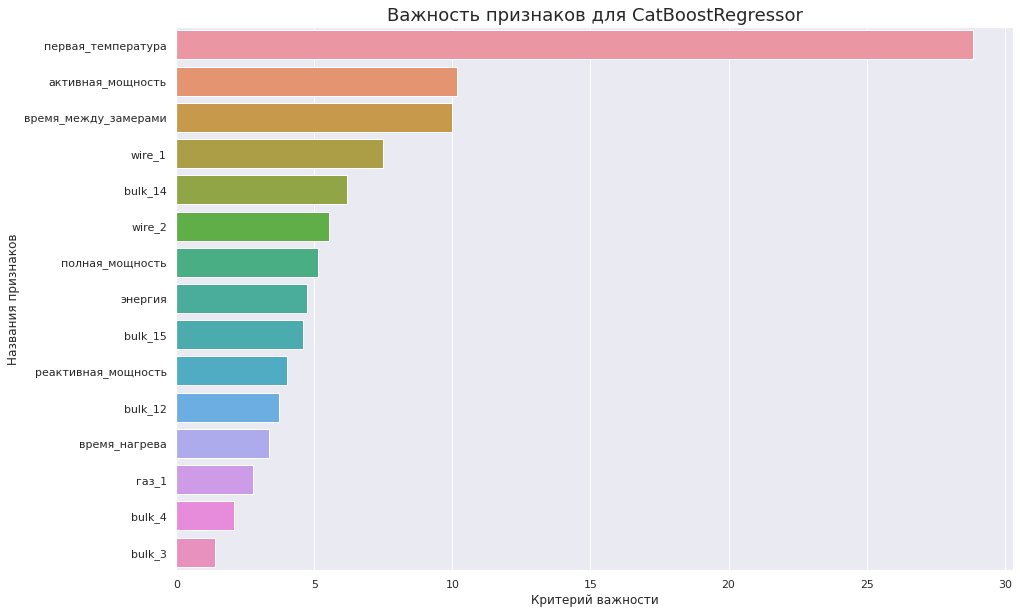

In [63]:
plot_data = {
    'features': X_test.columns,
    'feature_importances': model_shap.feature_importances_,
}
plot_data = pd.DataFrame(plot_data)
plot_data.sort_values(by='feature_importances', ascending=False, inplace=True)
plt.figure()
sns.barplot(x=plot_data['feature_importances'], y=plot_data['features'])
plt.title('Важность признаков для CatBoostRegressor', fontsize=18)
plt.xlabel('Критерий важности')
plt.ylabel('Названия признаков')
plt.show()

**Вывод:** Вывел сводную таблицу 4-х моделей с временем обучения, предсказания и метрикой MAE. Лучший результат показала модель CatBoostRegressor. Измерив метрику на тестовых данных модели CatBoostRegressor, MAE показал результат = 6. 

Так же рассичал метрику  коэффициента детерминации(r2), она равняется 0.48.Коэффициент детерминации оценивает обобщающую способность модели. Модель примерно в 50% процентах случаев предсказывает ближе к истине, чем среднее значение целевого признака.

Далее посмотрел метрику на константной модели DummyRegressor, результат MAE=8.5. Выбор модели и подбор гиперпараметров значительно улучшил метрику MAE.

Вывел таблицу важности признаков модели. Самым важным признаком который выделяется от других *первая_температура*, далее идет *активная_мощность* и *время_между_замерами*. Наименее значимыми признакими оказались *газ_1* и *bulk_4*, *bulk_3*

## Шаг. Общий вывод и рекомендации заказчику

По итогам проделанной работы было сделанно следующее:
### Открыл файл с данными и изучил иформацию
- Загрузил данные из файлов в датафреймы.
- Вывел первые строки,изучил общую информацию о датафреймах.Данные представлены в 7 таблицах.
- Вывел первые 5 строк всех таблиц
- Вывел информацию о таблицах, наблюдаю большое колличество пропусков в данных и разное колличество строк.
- Привел название столбцов в змеиный и нижний регистр.
- Вывел информацию о дубликатах,их нет. 
- Вывел набор статистических данных, в которых наблюдаю большой разброс.
- Вывел гистограммы и ящики с усами для некоторых столбцов,наблюдаю наличие выбросов и аномалий.
### Предобработал данные
В столбце data arc
- Вывел строку с (аномальной) отрицательной реактивной мощностью и удалил ее.
- Добавил новый признак время нагрева в секундах(разница между началом и концом нагрева дугой).
- Агрегировал данные по ключу.
- Добавил новый признак полная мощность путем вычисления по формуле.
- Добавил новый признак энергия, вычисляемый по формуле.

В столбце data bulk 
- Оставил только те столбцы, в которых процент пропусков меньше 80%(в колличестве 5 столбцов), остальные заполнил нулями.

В столбце data wire 
- Оставил только те столбцы, в которых процент пропусков меньше 80%(в колличестве 2 столбцов), остальные заполнил нулями.

В столбце data temp
- Удалил строки с температурой, наже 1500
- Отсортировал данные по колличеству ключей(замеров температуры) и если их меньше 2-х, то они не подходят для предсказания их удалил. Максимальное значение ключа 2499, и оставшееся колличество строк ровняется 12261. 
- Далее добавил новые 3 признака первое_время_замера, последнее_время_замера и время_между_замерами.
### Объединил таблицы
- Объединил 5 методом merge, получилось 2328 строк.
- Далее удалил столбец с ключами, и с датой и временем, они больше не понадобятся. 
- Вывел гистограммы и boxplot для всех признаков объедененной выборки 
### Провел исследовательский анализ объединённого датафрейма
- Провел корреляционный анализ и вывел heatmap, есть сильная зависимость(больше 0.9) у столбцов, которые были включены в формулы,а именно у столбца 'энергия' с 'активная_мощность', 'реактивная_мощность', 'время_нагрева', 'полная_мощность', они будут удалены при обучении линейной регрессии. Так же зависимсть более 0.8 между признаком 'время_между_замерами' и 'активная_мощность', 'реактивная_мощность', между 'bulk_14' и 'активная_мощность', 'bulk_12', 'газ_1'
### Обучил модели машинного обучения
Выделил признаки и целевой признак и разбил выборку на train и test в соотношении 75/25. Размер тестовой выборки получился 1746 строк, а тренировочной 582.

Обучил 4 модели:

- CatBoostRegressor на кросс-валидации с подбором гиперпараметров через  GridSearchCV.Модель обучалась около 3,5 минут и показала хороший результат метрики MAE=5.68
-  DecisionTreeRegressor  на кросс-валидации с подбором гиперпараметров через  GridSearchCV.Модель обучалась 14 секунд и показала метрику MAE=6,9
- RandomForestRegressor на кросс-валидации с подбором гиперпараметров через  GridSearchCV.Модель обучалась 12 секунд и показала хороший результат метрики MAE=5.85
- LinearRegression  на кросс-валидации средний результат метрики MAE=6.07.Перед обучением удалил сильно коррелирующие признаки и масштабировал данные перед обучением.
### Выбрал лучшую модель
- Вывел сводную таблицу 4-х моделей с временем обучения, предсказания и метрикой MAE. 

- Рассчитал метрику коэффициента детерминации(r2), она равняется 0.48.Коэффициент детерминации оценивает обобщающую способность модели. Модель примерно в 50% процентах случаев предсказывает ближе к истине, чем среднее значение целевого признака.

- Посмотрел метрику на константной модели DummyRegressor, результат MAE=8.5. Выбор модели и подбор гиперпараметров значительно улучшил метрику MAE.

- Вывел таблицу важности признаков модели. Самым важным признаком который выделяется от других *первая_температура*, далее идет *активная_мощность* и *время_между_замерами*. Наименее значимыми признакими оказались *газ_1* и *bulk_4*, *bulk_3*.

Лучший результат MAE=5.68, показала модель *CatBoostRegressor* с гиперпараметрами depth = 8, iterations = 100, learning_rate = 0.1, random_state=50824. Измерив метрику на тестовых данных модели CatBoostRegressor, MAE показал результат = 6, и в сравнении с константной моделью,результат очень хороший.

